In [2]:
# data packages
import pandas as pd
import numpy as np
from datetime import datetime
from math import ceil
import warnings
warnings.filterwarnings("ignore")

# plots
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

# processing
from sklearn.impute import KNNImputer
from collections import Counter
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, OneHotEncoder
from sklearn.base import clone

# clustering models
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN, KMeans, AgglomerativeClustering

# metrics
from scipy.cluster.hierarchy import dendrogram
from sklearn.metrics import silhouette_score, silhouette_samples

# multidimensional visualization methods
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import graphviz
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import train_test_split
sns.set()
%matplotlib inline

# Business Understanding: 
https://github.com/joaopfonseca/business-cases-21-22/tree/main/BC1_customer_segmentation

# Data Understanding: 

### Data Exploration
- view the original dataset
- outliers
- null values

In [3]:
# read the dataset
df = pd.read_excel('WonderfulWinesoftheWorld.xlsx')
df.Custid.fillna(11001.0, inplace=True)
df.set_index('Custid', inplace = True)

In [4]:
# create a copy of the original df for preprocessing
df_backup = df.copy()

In [5]:
# first rows - view the structure
df.head()

Dayswus   Age   Edu    Income  Freq  Recency  Monetary    LTV  \
Custid                                                                  
5325.0    653.0  55.0  20.0   78473.0  20.0     18.0     826.0  445.0   
3956.0   1041.0  75.0  18.0  105087.0  36.0     33.0    1852.0  539.0   
3681.0    666.0  18.0  12.0   27984.0   4.0     56.0      39.0   -7.0   
2829.0   1049.0  42.0  16.0   61748.0   2.0     46.0      37.0   -6.0   
8788.0    837.0  47.0  16.0   65789.0   2.0      3.0      36.0    4.0   

        Perdeal  Dryred  Sweetred  Drywh  Sweetwh  Dessert  Exotic  \
Custid                                                               
5325.0      7.0    67.0       4.0   26.0      2.0      1.0     1.0   
3956.0      2.0    49.0       0.0   46.0      1.0      3.0     0.0   
3681.0     88.0     4.0      29.0   14.0     32.0     21.0    48.0   
2829.0     70.0    86.0       1.0   11.0      1.0      1.0    55.0   
8788.0     35.0    85.0       0.0   12.0      2.0      1.0    28.0   

        WebPurchase  WebVisit  
Custid                         
5325.0         36.0       5.0  
3956.0         20.0       4.0  
3681.0         60.0       8.0  
2829.0         59.0       7.0  
8788.0         63.0       6.0

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 10001 entries, 5325.0 to 11001.0
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Dayswus      10001 non-null  float64
 1   Age          10001 non-null  float64
 2   Edu          10001 non-null  float64
 3   Income       10001 non-null  float64
 4   Freq         10001 non-null  float64
 5   Recency      10001 non-null  float64
 6   Monetary     10001 non-null  float64
 7   LTV          10001 non-null  float64
 8   Perdeal      10001 non-null  float64
 9   Dryred       10001 non-null  float64
 10  Sweetred     10001 non-null  float64
 11  Drywh        10001 non-null  float64
 12  Sweetwh      10001 non-null  float64
 13  Dessert      10001 non-null  float64
 14  Exotic       10001 non-null  float64
 15  WebPurchase  10001 non-null  float64
 16  WebVisit     10001 non-null  float64
dtypes: float64(17)
memory usage: 1.4 MB


In [7]:
# Checking for missing values
df.isna().sum()

Dayswus        0
Age            0
Edu            0
Income         0
Freq           0
Recency        0
Monetary       0
LTV            0
Perdeal        0
Dryred         0
Sweetred       0
Drywh          0
Sweetwh        0
Dessert        0
Exotic         0
WebPurchase    0
WebVisit       0
dtype: int64

In [8]:
#Checking for duplicates: 
duplicate=df.duplicated()
print(duplicate.sum())
df[duplicate]

0


Empty DataFrame
Columns: [Dayswus, Age, Edu, Income, Freq, Recency, Monetary, LTV, Perdeal, Dryred, Sweetred, Drywh, Sweetwh, Dessert, Exotic, WebPurchase, WebVisit]
Index: []

In [9]:
df.describe().T

count        mean           std      min      25%      50%  \
Dayswus      10001.0    898.1020    202.482664    550.0    724.0    894.0   
Age          10001.0     47.9273     17.301856     18.0     33.0     48.0   
Edu          10001.0     16.7391      1.876281     12.0     15.0     17.0   
Income       10001.0  69904.3580  27610.852665  10000.0  47646.0  70009.0   
Freq         10001.0     14.6281     11.968475      1.0      4.0     12.0   
Recency      10001.0     62.4068     69.870762      0.0     26.0     52.0   
Monetary     10001.0    622.5552    647.102966      6.0     63.0    383.0   
LTV          10001.0    209.0712    291.971441   -178.0     -2.0     57.0   
Perdeal      10001.0     32.3972     27.895699      0.0      6.0     25.0   
Dryred       10001.0     50.3827     23.452643      1.0     32.0     51.0   
Sweetred     10001.0      7.0545      7.866151      0.0      2.0      4.0   
Drywh        10001.0     28.5213     12.583328      1.0     19.0     28.0   
Sweetwh      10001.0      7.0698      8.014682      0.0      2.0      4.0   
Dessert      10001.0      6.9474      7.879152      0.0      2.0      4.0   
Exotic       10001.0     16.5466     17.246809      0.0      4.0     10.0   
WebPurchase  10001.0     42.3762     18.521136      4.0     28.0     45.0   
WebVisit     10001.0      5.2166      2.330340      0.0      3.0      6.0   

                 75%       max  
Dayswus       1074.0    1250.0  
Age             63.0      78.0  
Edu             18.0      20.0  
Income       92147.0  140628.0  
Freq            24.0      56.0  
Recency         78.0     549.0  
Monetary      1077.0    3052.0  
LTV            364.0    1791.0  
Perdeal         56.0      97.0  
Dryred          69.0      99.0  
Sweetred        10.0      75.0  
Drywh           37.0      74.0  
Sweetwh         10.0      62.0  
Dessert          9.0      77.0  
Exotic          23.0      96.0  
WebPurchase     57.0      88.0  
WebVisit         7.0      10.0

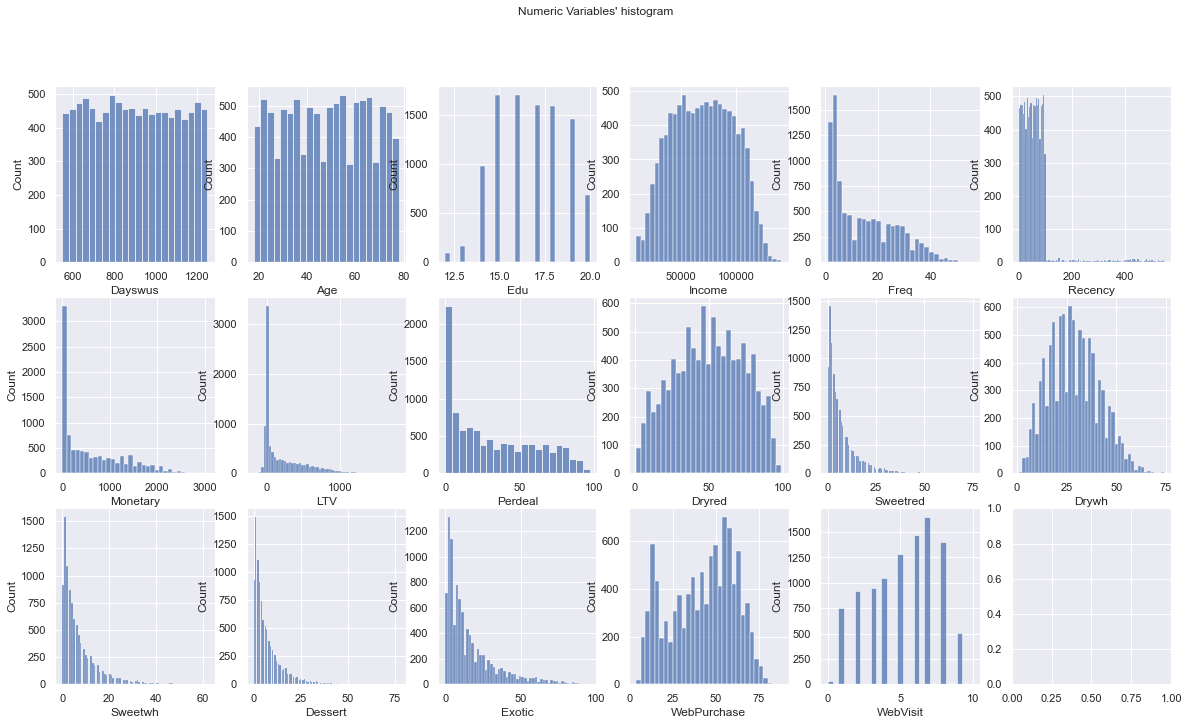

In [10]:
# plot outliers
%matplotlib inline
num_vars=df.select_dtypes(include=np.number).set_index(df.index)

# Prepare figure. Create individual axes where each box plot will be placed
fig, axes = plt.subplots(3, ceil(num_vars.shape[1] / 3), figsize=(20, 11))

# Plot data
# Iterate across axes objects and associate each box plot (hint: use the ax argument):
for ax, feat in zip(axes.flatten(), num_vars): # Notice the zip() function and flatten() method
    sns.histplot(x=num_vars[feat], ax=ax)
    
# Layout
# Add a centered title to the figure:
title = "Numeric Variables' histogram"

plt.suptitle(title)

plt.show()


### Outliers

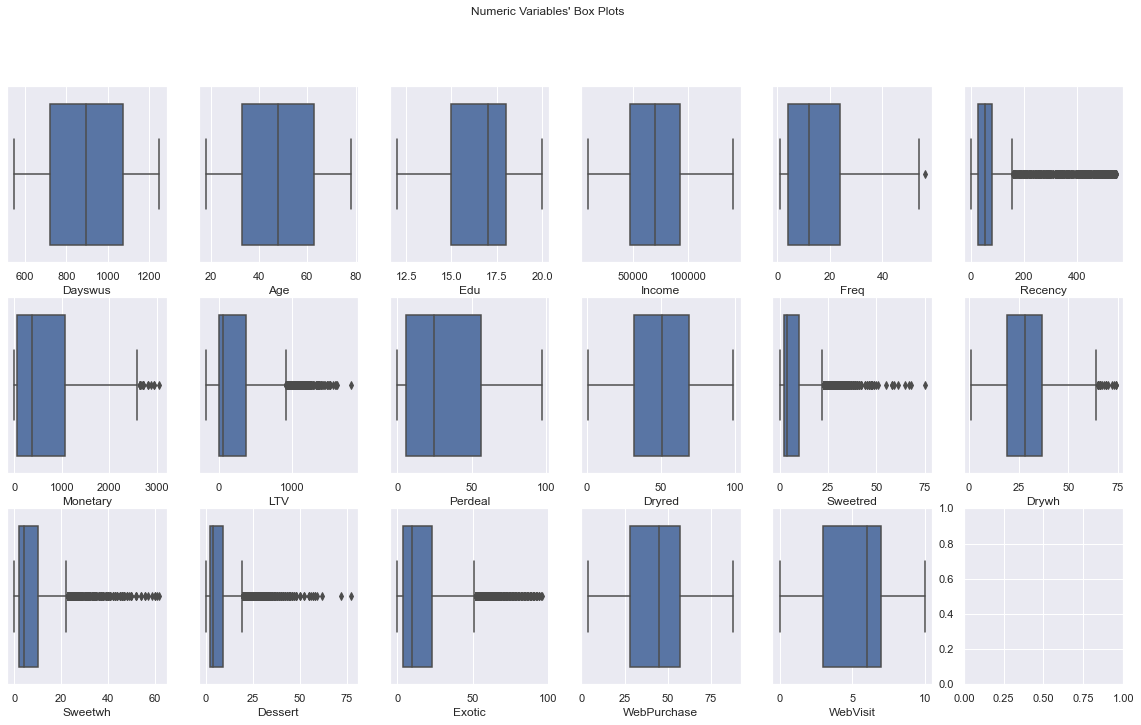

In [11]:
# plot outliers
%matplotlib inline
num_vars=df.select_dtypes(include=np.number).set_index(df.index)

# Prepare figure. Create individual axes where each box plot will be placed
fig, axes = plt.subplots(3, ceil(num_vars.shape[1] / 3), figsize=(20, 11))

# Plot data
# Iterate across axes objects and associate each box plot (hint: use the ax argument):
for ax, feat in zip(axes.flatten(), num_vars): # Notice the zip() function and flatten() method
    sns.boxplot(x=num_vars[feat], ax=ax)
    
# Layout
# Add a centered title to the figure:
title = "Numeric Variables' Box Plots"

plt.suptitle(title)

plt.show()

# Data Preparation:

## Dealing with Outliers: 

## DBscan

In [12]:
# Robust Scaler - Scale features using statistics that are robust to outliers.
robust = RobustScaler().fit(df)
df_norm = robust.transform(df)

# Convert the array to a pandas dataframe
df_norm = pd.DataFrame(df_norm, columns=df.columns).set_index(df.index)

In [13]:
df_norm.describe().T

count      mean       std       min       25%  50%       75%  \
Dayswus      10001.0  0.011720  0.578522 -0.982857 -0.485714  0.0  0.514286   
Age          10001.0 -0.002423  0.576729 -1.000000 -0.500000  0.0  0.500000   
Edu          10001.0 -0.086967  0.625427 -1.666667 -0.666667  0.0  0.333333   
Income       10001.0 -0.002351  0.620455 -1.348487 -0.502528  0.0  0.497472   
Freq         10001.0  0.131405  0.598424 -0.550000 -0.400000  0.0  0.600000   
Recency      10001.0  0.200131  1.343668 -1.000000 -0.500000  0.0  0.500000   
Monetary     10001.0  0.236248  0.638169 -0.371795 -0.315582  0.0  0.684418   
LTV          10001.0  0.415495  0.797736 -0.642077 -0.161202  0.0  0.838798   
Perdeal      10001.0  0.147944  0.557914 -0.500000 -0.380000  0.0  0.620000   
Dryred       10001.0 -0.016684  0.633855 -1.351351 -0.513514  0.0  0.486486   
Sweetred     10001.0  0.381812  0.983269 -0.500000 -0.250000  0.0  0.750000   
Drywh        10001.0  0.028961  0.699074 -1.500000 -0.500000  0.0  0.500000   
Sweetwh      10001.0  0.383725  1.001835 -0.500000 -0.250000  0.0  0.750000   
Dessert      10001.0  0.421057  1.125593 -0.571429 -0.285714  0.0  0.714286   
Exotic       10001.0  0.344558  0.907727 -0.526316 -0.315789  0.0  0.684211   
WebPurchase  10001.0 -0.090476  0.638660 -1.413793 -0.586207  0.0  0.413793   
WebVisit     10001.0 -0.195850  0.582585 -1.500000 -0.750000  0.0  0.250000   

                   max  
Dayswus       1.017143  
Age           1.000000  
Edu           1.000000  
Income        1.586908  
Freq          2.200000  
Recency       9.557692  
Monetary      2.632150  
LTV           4.737705  
Perdeal       1.440000  
Dryred        1.297297  
Sweetred      8.875000  
Drywh         2.555556  
Sweetwh       7.250000  
Dessert      10.428571  
Exotic        4.526316  
WebPurchase   1.482759  
WebVisit      1.000000

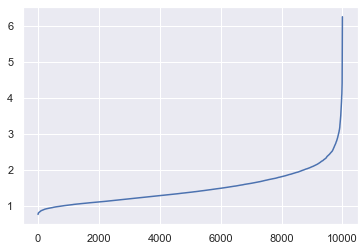

In [14]:
# K-distance graph to find out the right eps value
neigh = NearestNeighbors(n_neighbors=20)
neigh.fit(df_norm)
distances, _ = neigh.kneighbors(df_norm)
distances = np.sort(distances[:, -1])
plt.plot(distances)
plt.show()

In [15]:
dbscan = DBSCAN(eps=2.7, min_samples=20, n_jobs=6)
dbscan_labels = dbscan.fit_predict(df_norm)
Counter(dbscan_labels)

Counter({0: 9941, -1: 60})

In [16]:
# Save the newly detected outliers (they will be classified later based on the final clusters)
df_out = df[dbscan_labels==-1].copy()

# New df without outliers
df = df[dbscan_labels!=-1]\
    .copy()

# New df without outliers
df_norm = df_norm[dbscan_labels!=-1]\
    .copy()

In [17]:
df=df.reset_index(drop=True)

In [18]:
df_norm=df_norm.reset_index(drop=True)

In [19]:
df.shape

(9941, 17)

In [20]:
df_backup.shape

(10001, 17)

## Feature selection: Correlation matrix

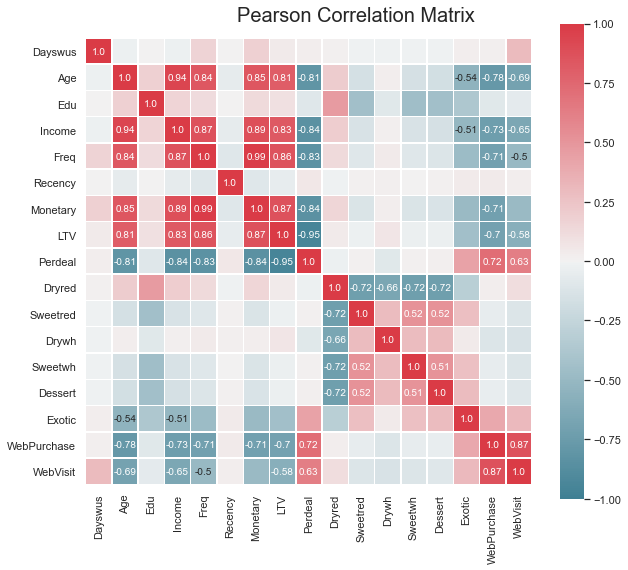

In [21]:
# Prepare figure
fig = plt.figure(figsize=(10, 8))

# Obtain correlation matrix. Round the values to 2 decimal cases. Use the DataFrame corr() and round() method.
corr = np.round(df.corr(method="spearman"), decimals=2)

# Build annotation matrix (values above |0.5| will appear annotated in the plot)
mask_annot = np.absolute(corr.values) >= 0.5
annot = np.where(mask_annot, corr.values, np.full(corr.shape,""))

# Plot heatmap of the correlation matrix
sns.heatmap(data=corr, annot=annot, cmap=sns.diverging_palette(220, 10, as_cmap=True), 
            fmt='s', vmin=-1, vmax=1, center=0, square=True, linewidths=.5)

# Layout
fig.subplots_adjust(top=0.95)
fig.suptitle("Pearson Correlation Matrix", fontsize=20)

plt.show()

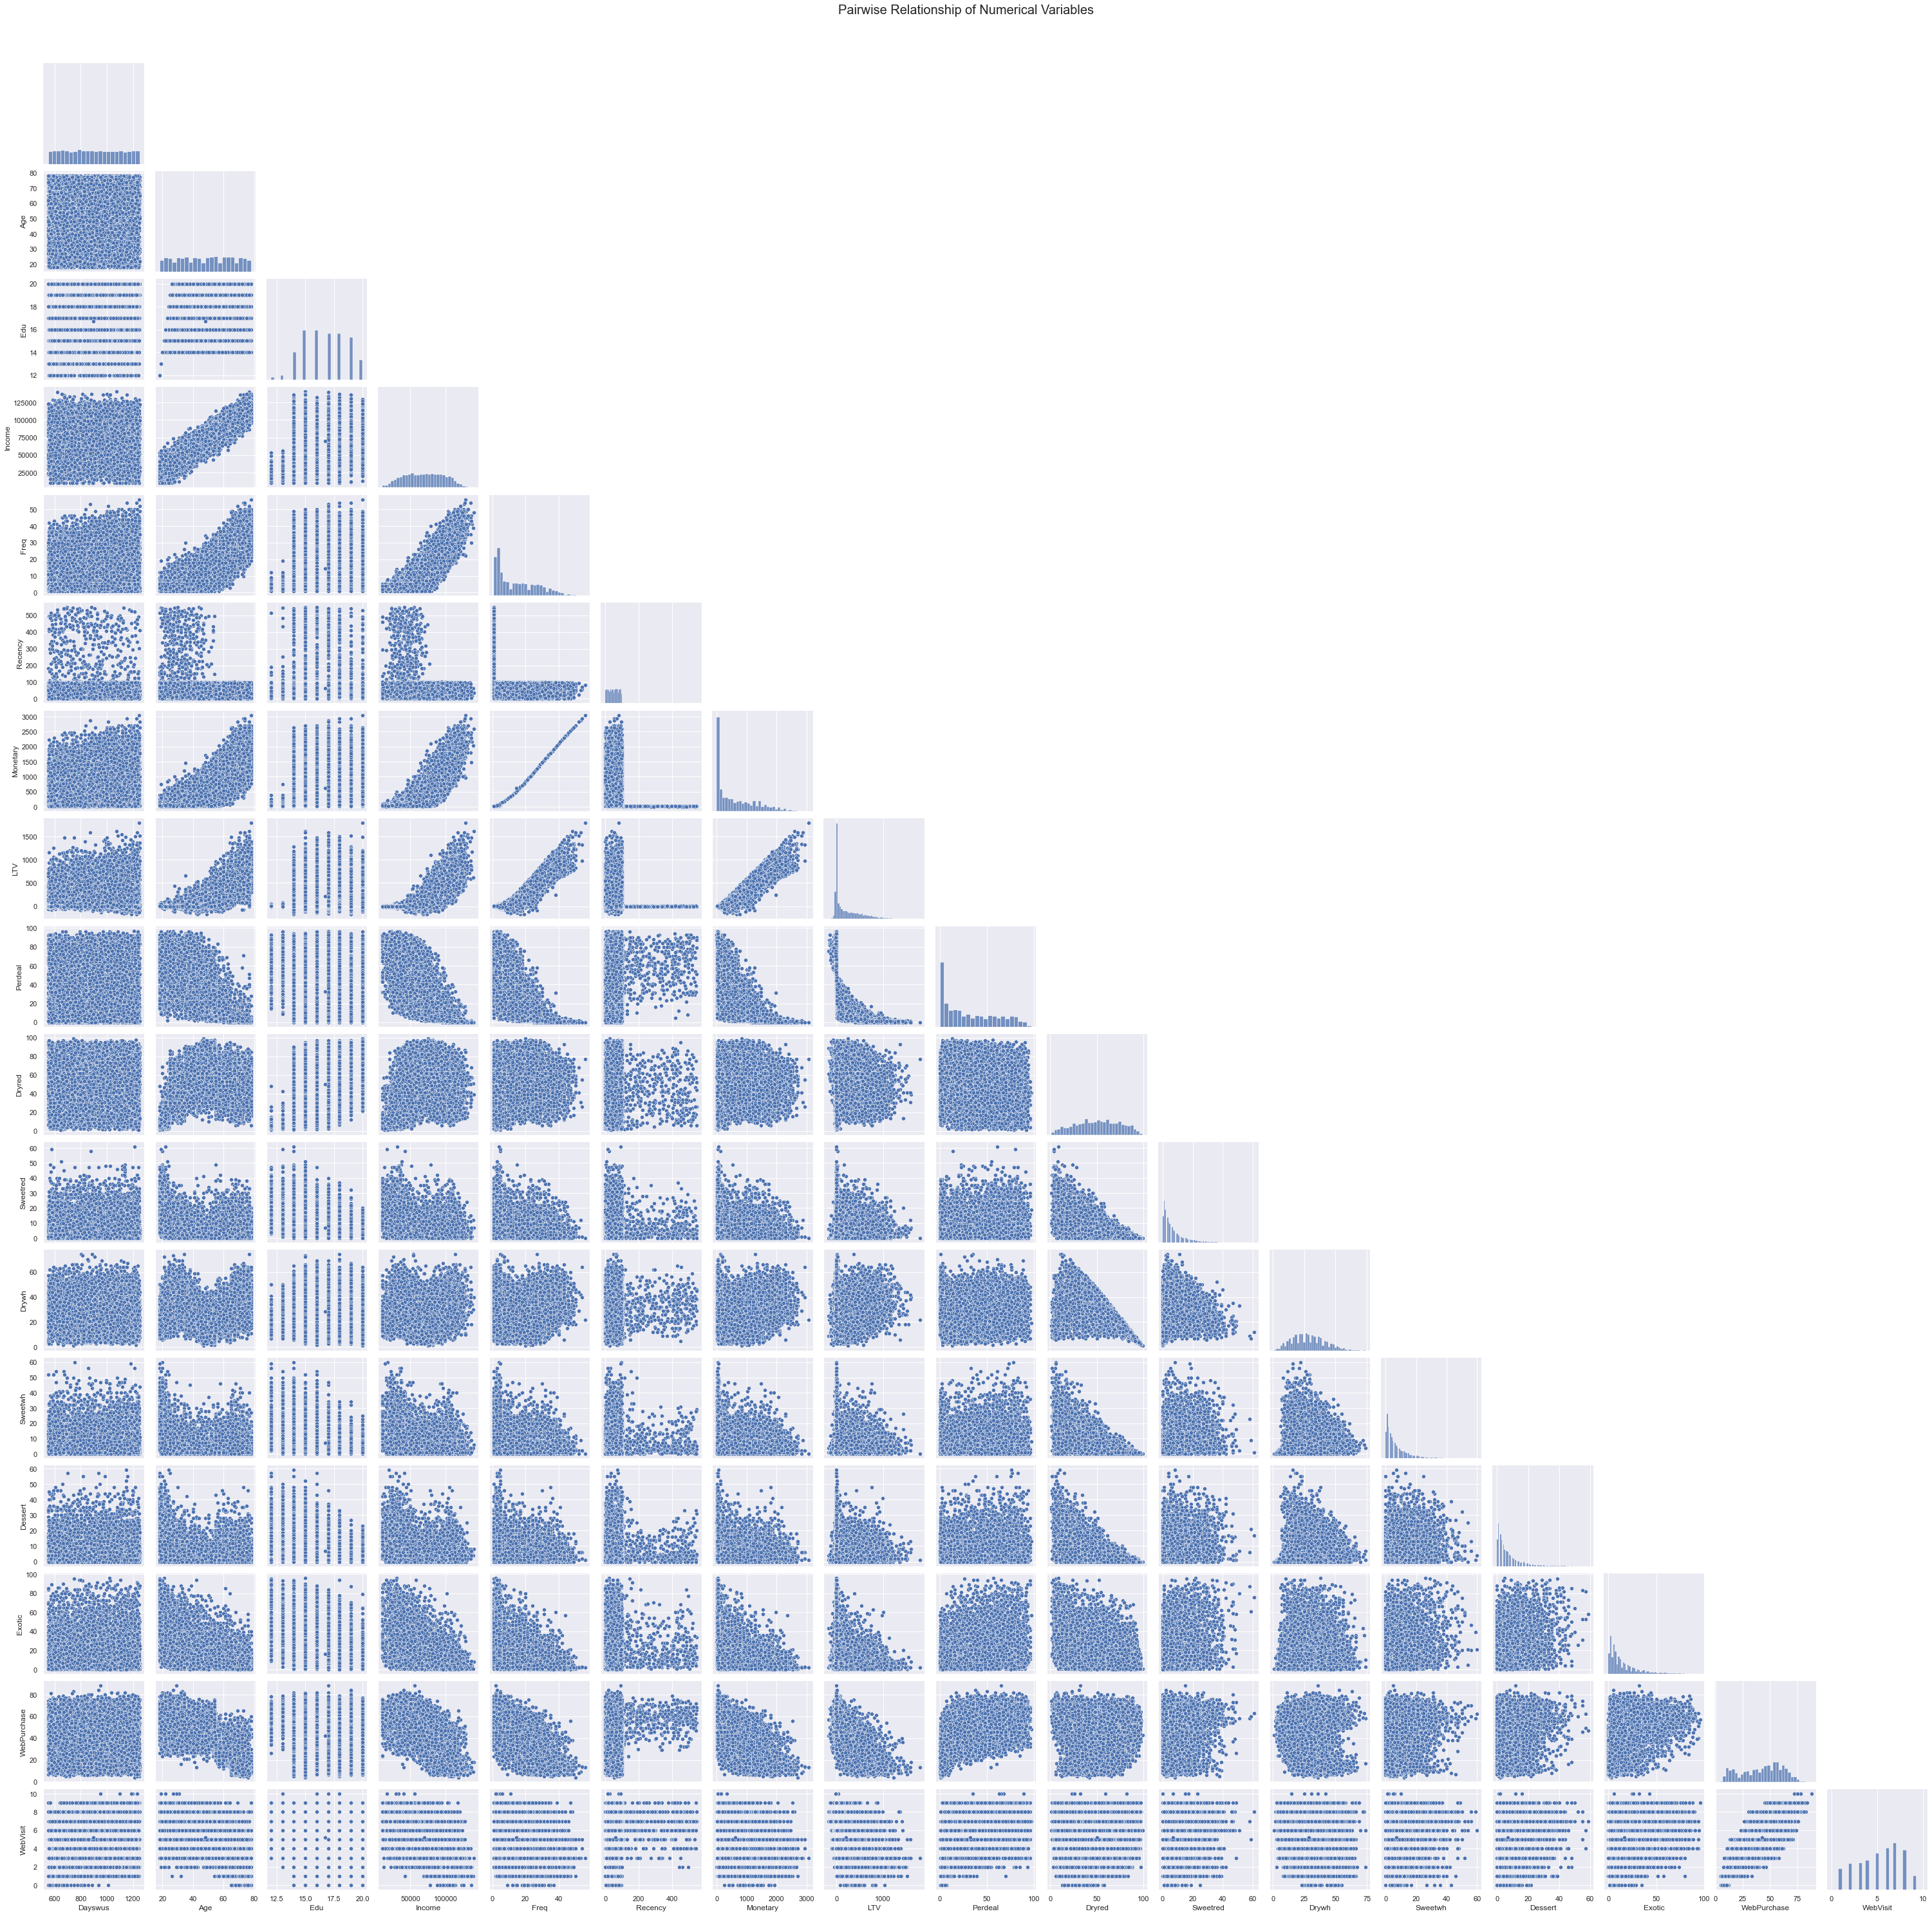

In [22]:
# Pairwise Relationship of Numerical Variables
sns.set()

# Setting pairplot
sns.pairplot(df, diag_kind="hist", corner=True)

# Layout
plt.subplots_adjust(top=0.95)
plt.suptitle("Pairwise Relationship of Numerical Variables", fontsize=20)

plt.show()

### Feature Engineering:

In [23]:
#years as customer
df["YearsAsCustomer"]=round(df.Dayswus/365,1)

#income
df["logIncome"]=df["Income"].map(lambda x : 1 if x<=1 else x)
df["logIncome"]=np.log(df["logIncome"])

#LTV
df["logLTV"]=df["LTV"].map(lambda x : 1 if x<=1 else x)
df["logLTV"]=np.log(df["logLTV"])

#RFM variable
df["FrequencyScore"] = pd.cut(df["Freq"], 
                                       bins=[-1, 
                                         np.percentile(df["Freq"], 25), 
                                             np.percentile(df["Freq"], 50), 
                                             np.percentile(df["Freq"], 75), 
                                             df["Freq"].max()], 
                                       labels=[1, 2, 3, 4]).astype("int")

df["RecencyScore"] = pd.cut(df["Recency"], 
                                       bins=[-1, 
                                         np.percentile(df["Recency"], 25), 
                                             np.percentile(df["Recency"], 50), 
                                             np.percentile(df["Recency"], 75), 
                                             df["Recency"].max()], 
                                       labels=[4, 3, 2, 1]).astype("int")

df["MonetaryScore"] = pd.cut(df["Monetary"], 
                                       bins=[-1, 
                                         np.percentile(df["Monetary"], 25), 
                                             np.percentile(df["Monetary"], 50), 
                                             np.percentile(df["Monetary"], 75), 
                                             df["Monetary"].max()], 
                                       labels=[1, 2, 3, 4]).astype("int")

df["RFM"] = df["RecencyScore"] + df["FrequencyScore"] + df["MonetaryScore"]

In [24]:
#years as customer
df_out["YearsAsCustomer"]=round(df_out.Dayswus/365,1)

#income
df_out["logIncome"]=df_out["Income"].map(lambda x : 1 if x<=1 else x)
df_out["logIncome"]=np.log(df_out["logIncome"])

#LTV
df_out["logLTV"]=df_out["LTV"].map(lambda x : 1 if x<=1 else x)
df_out["logLTV"]=np.log(df_out["logLTV"])

#RFM variable
df_out["FrequencyScore"] = pd.cut(df_out["Freq"], 
                                       bins=[-1, 
                                         np.percentile(df["Freq"], 25), 
                                             np.percentile(df["Freq"], 50), 
                                             np.percentile(df["Freq"], 75), 
                                             df["Freq"].max()], 
                                       labels=[1, 2, 3, 4]).astype("int")

df_out["RecencyScore"] = pd.cut(df_out["Recency"], 
                                       bins=[-1, 
                                         np.percentile(df["Recency"], 25), 
                                             np.percentile(df["Recency"], 50), 
                                             np.percentile(df["Recency"], 75), 
                                             df["Recency"].max()], 
                                       labels=[4, 3, 2, 1]).astype("int")

df_out["MonetaryScore"] = pd.cut(df_out["Monetary"], 
                                       bins=[-1, 
                                         np.percentile(df["Monetary"], 25), 
                                             np.percentile(df["Monetary"], 50), 
                                             np.percentile(df["Monetary"], 75), 
                                             df["Monetary"].max()], 
                                       labels=[1, 2, 3, 4]).astype("int")

df_out["RFM"] = df_out["RecencyScore"] + df_out["FrequencyScore"] + df_out["MonetaryScore"]

## PCA

In [25]:
# Robust Scaler - Scale features using statistics that are robust to outliers.
robust = RobustScaler().fit(df)
df_norm = robust.transform(df)

# Convert the array to a pandas dataframe
df_norm = pd.DataFrame(df_norm, columns=df.columns).set_index(df.index)

In [26]:
df_pca = df_norm[['Dayswus', 'Age', 'Edu', 'Income', 'Freq', 'Recency', 'Monetary', 'LTV',
       'Perdeal','WebPurchase', 'WebVisit', 'YearsAsCustomer', 'logIncome',
       'logLTV']].copy()

In [27]:
pca = PCA()
pca_feat = pca.fit_transform(df_pca)

# Output PCA table
pd.DataFrame(
    {"Eigenvalue": pca.explained_variance_,
     "Difference": np.insert(np.diff(pca.explained_variance_), 0, 0),
     "Proportion": pca.explained_variance_ratio_,
     "Cumulative": np.cumsum(pca.explained_variance_ratio_)},
    index=range(1, pca.n_components_ + 1)
).round(4)

Eigenvalue  Difference  Proportion  Cumulative
1       3.1776      0.0000      0.4817      0.4817
2       1.5391     -1.6385      0.2333      0.7151
3       0.7946     -0.7445      0.1205      0.8355
4       0.3983     -0.3963      0.0604      0.8959
5       0.2380     -0.1603      0.0361      0.9320
6       0.2181     -0.0200      0.0331      0.9650
7       0.1172     -0.1008      0.0178      0.9828
8       0.0430     -0.0742      0.0065      0.9893
9       0.0321     -0.0109      0.0049      0.9942
10      0.0192     -0.0129      0.0029      0.9971
11      0.0115     -0.0077      0.0017      0.9989
12      0.0060     -0.0055      0.0009      0.9998
13      0.0010     -0.0050      0.0001      0.9999
14      0.0005     -0.0005      0.0001      1.0000

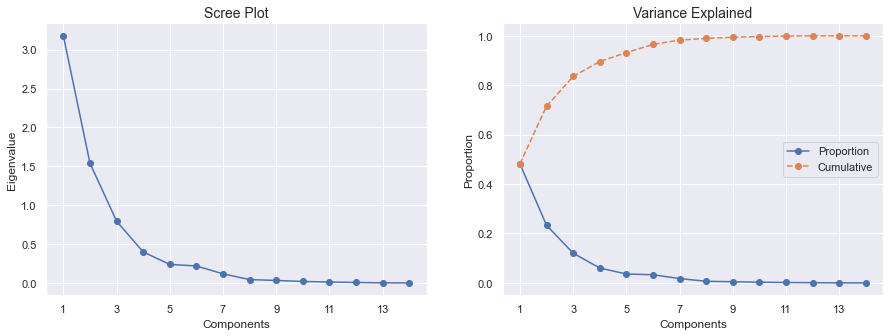

In [28]:
# figure and axes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# draw plots
ax1.plot(pca.explained_variance_, marker=".", markersize=12)
ax2.plot(pca.explained_variance_ratio_, marker=".", markersize=12, label="Proportion")
ax2.plot(np.cumsum(pca.explained_variance_ratio_), marker=".", markersize=12, linestyle="--", label="Cumulative")

# customizations
ax2.legend()
ax1.set_title("Scree Plot", fontsize=14)
ax2.set_title("Variance Explained", fontsize=14)
ax1.set_ylabel("Eigenvalue")
ax2.set_ylabel("Proportion")
ax1.set_xlabel("Components")
ax2.set_xlabel("Components")
ax1.set_xticks(range(0, pca.n_components_, 2))
ax1.set_xticklabels(range(1, pca.n_components_ + 1, 2))
ax2.set_xticks(range(0, pca.n_components_, 2))
ax2.set_xticklabels(range(1, pca.n_components_ + 1, 2))

plt.show()

- the first two Coponents explain 70% of the variance
- the first four Components explain 90% of the variance

In [29]:
# testing PCA with the 4 principal components
pca = PCA(n_components=4)
pca_feat = pca.fit_transform(df_pca)
pca_feat_names = [f"PC{i}" for i in range(pca.n_components_)]
pca_df = pd.DataFrame(pca_feat, index=df_pca.index, columns=pca_feat_names)
pca_df

PC0       PC1       PC2       PC3
0     1.192423 -0.520938 -0.940179 -0.879101
1     2.603452  0.030786  0.691237 -0.250649
2    -2.494983 -0.643833 -0.679103  1.597182
3    -1.291758 -0.624540  0.567118 -0.070560
4    -0.738166 -1.314740 -0.392995 -0.039754
...        ...       ...       ...       ...
9936  1.391263  0.073132 -1.462974  0.735699
9937 -1.649012 -0.268472 -1.125814  1.573649
9938 -2.687084  5.389537  0.942305  0.017639
9939  1.343795 -0.368761  0.351696  0.193810
9940  0.115093  0.048076  0.029016 -0.024016

[9941 rows x 4 columns]

In [30]:
# Reassigning df to contain pca variables
df_pca = pd.concat([df_pca, pca_df], axis=1)
df_pca.head()

Dayswus       Age       Edu    Income  Freq   Recency  Monetary       LTV  \
0 -0.688571  0.233333  1.000000  0.185938   0.4 -0.653846  0.434911  1.048913   
1  0.420000  0.900000  0.333333  0.787806   1.2 -0.365385  1.446746  1.304348   
2 -0.651429 -1.000000 -1.666667 -0.955856  -0.4  0.076923 -0.341223 -0.179348   
3  0.442857 -0.200000 -0.333333 -0.192293  -0.5 -0.115385 -0.343195 -0.176630   
4 -0.162857 -0.033333 -0.333333 -0.100907  -0.5 -0.942308 -0.344181 -0.149457   

   Perdeal  WebPurchase  WebVisit  YearsAsCustomer  logIncome    logLTV  \
0    -0.36    -0.300000     -0.25        -0.666667   0.169543  0.342311   
1    -0.46    -0.833333     -0.50         0.555556   0.616888  0.374778   
2     1.26     0.500000      0.50        -0.666667  -1.409957 -0.690800   
3     0.90     0.466667      0.25         0.555556  -0.197625 -0.690800   
4     0.20     0.600000      0.00        -0.111111  -0.100521 -0.455939   

        PC0       PC1       PC2       PC3  
0  1.192423 -0.520938 -0.940179 -0.879101  
1  2.603452  0.030786  0.691237 -0.250649  
2 -2.494983 -0.643833 -0.679103  1.597182  
3 -1.291758 -0.624540  0.567118 -0.070560  
4 -0.738166 -1.314740 -0.392995 -0.039754

In [31]:
def _color_red_or_green(val):
    if val < -0.45:
        color = 'background-color: red'
    elif val > 0.45:
        color = 'background-color: green'
    else:
        color = ''
    return color

# Interpreting each Principal Component
loadings = df_pca.corr().loc[['Dayswus', 'Age', 'Edu', 'Income', 'Freq', 'Recency', 'Monetary', 'LTV',
       'Perdeal','WebPurchase', 'WebVisit', 'YearsAsCustomer', 'logIncome',
       'logLTV'], pca_feat_names]
loadings.style.applymap(_color_red_or_green)

PCA0 is almost exlusively the combination of income/frequency/age/LTV, which all seem to have lots of overlap 
PCA1 is Recency, meaning we should probably include it in the clustering 
PCA2 is years as customer (40% webvisit) 
PCA3 is education
the rest are useless 

so given the PCA analysis and the correlation analysis we will try clustering with a combination of the following: 
- LTV/logLTV
- per deal
- recency 
- years as customer 
- education
- webvisit 

In [32]:
df.to_csv('cleaned_data.csv', index_label='Custid')

In [33]:
df_out.to_csv('outliers.csv', index_label='Custid')

In [34]:
df = pd.read_csv('cleaned_data.csv')
df.set_index('Custid', inplace = True)
df_out = pd.read_csv('outliers.csv')
df_out.set_index('Custid', inplace = True)

#### Final data normalization: 

In [35]:
# Robust Scaler - Scale features using statistics that are robust to outliers.
robust = RobustScaler().fit(df)
df_norm = robust.transform(df)

# Convert the array to a pandas dataframe
df_norm = pd.DataFrame(df_norm, columns=df.columns).set_index(df.index)

In [36]:
df_out_norm = robust.transform(df_out)
df_out_norm = pd.DataFrame(df_out_norm, columns=df_out.columns).set_index(df_out.index)

# Modeling: 

In [88]:
# Final data quality check: 

In [37]:
#Variables included in clustering: 
clust=['LTV', 'Perdeal', 'YearsAsCustomer', 'Edu', 'WebVisit']

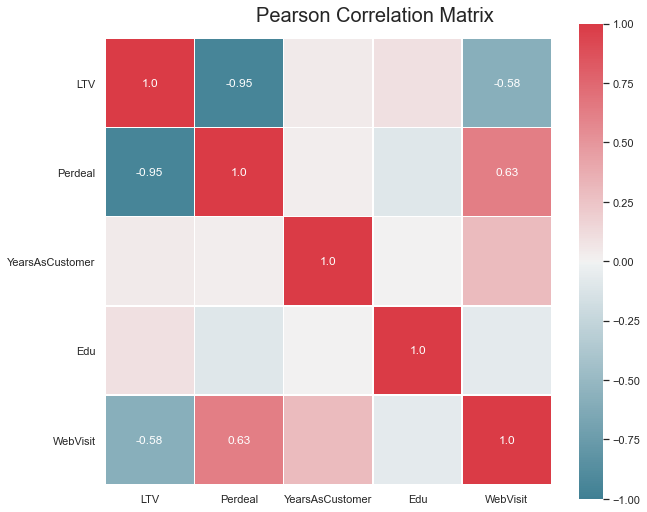

In [38]:
# Prepare figure
fig = plt.figure(figsize=(10, 8))

# Obtain correlation matrix. Round the values to 2 decimal cases. Use the DataFrame corr() and round() method.
corr = np.round(df[clust].corr(method="spearman"), decimals=2)

# Build annotation matrix (values above |0.5| will appear annotated in the plot)
mask_annot = np.absolute(corr.values) >= 0.5
annot = np.where(mask_annot, corr.values, np.full(corr.shape,""))

# Plot heatmap of the correlation matrix
sns.heatmap(data=corr, annot=annot, cmap=sns.diverging_palette(220, 10, as_cmap=True), 
            fmt='s', vmin=-1, vmax=1, center=0, square=True, linewidths=.5)

# Layout
fig.subplots_adjust(top=0.95)
fig.suptitle("Pearson Correlation Matrix", fontsize=20)

plt.show()

In [21]:
# Keep either LTV or Perdeal

In [39]:
value=['LTV', 'YearsAsCustomer', 'Edu', 'WebVisit']
pref=['Dryred','Sweetred','Drywh','Sweetwh','Dessert','Exotic']
df_val = df_norm[value].copy()
df_pr = df_norm[pref].copy()

### K-means:

### Defining the number of clusters:
#### Value Features: 

In [40]:
range_clusters = range(1, 15)
inertia = []
for n_clus in range_clusters:  # iterate over desired ncluster range
    kmclust = KMeans(n_clusters=n_clus, init='k-means++', n_init=15, random_state=1)
    kmclust.fit(df_val)
    inertia.append(kmclust.inertia_)

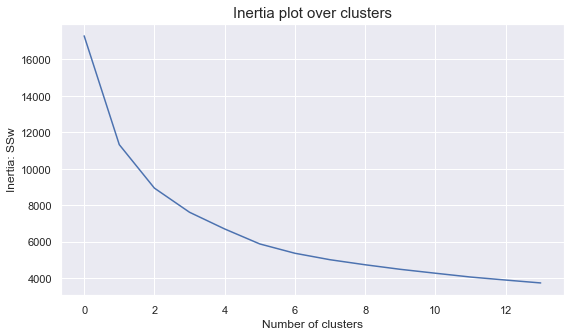

In [41]:
# The inertia plot
plt.figure(figsize=(9,5))
plt.plot(inertia)
#ax.set_xlim(1, 24)
plt.ylabel("Inertia: SSw")
plt.xlabel("Number of clusters")
plt.title("Inertia plot over clusters", size=15)
plt.show()

We do not have a very distinct elbow point here. The optimum value of k can be around 2–6 from the above plot as inertia continues to drop steeply at least till k=4. And since we didn’t get a direct answer, we can also use the silhouette method. 

For n_clusters = 2, the average silhouette_score is : 0.3545919252451528
For n_clusters = 3, the average silhouette_score is : 0.26728135794312885
For n_clusters = 4, the average silhouette_score is : 0.2533096170018578
For n_clusters = 5, the average silhouette_score is : 0.246620454476348
For n_clusters = 6, the average silhouette_score is : 0.24480560151008066
For n_clusters = 7, the average silhouette_score is : 0.24916544623128092
For n_clusters = 8, the average silhouette_score is : 0.2486960361028291
For n_clusters = 9, the average silhouette_score is : 0.23640083097746165
For n_clusters = 10, the average silhouette_score is : 0.23823725131352577
For n_clusters = 11, the average silhouette_score is : 0.2303710526193787
For n_clusters = 12, the average silhouette_score is : 0.2307011299841426
For n_clusters = 13, the average silhouette_score is : 0.22736764857421035
For n_clusters = 14, the average silhouette_score is : 0.22643153638626262


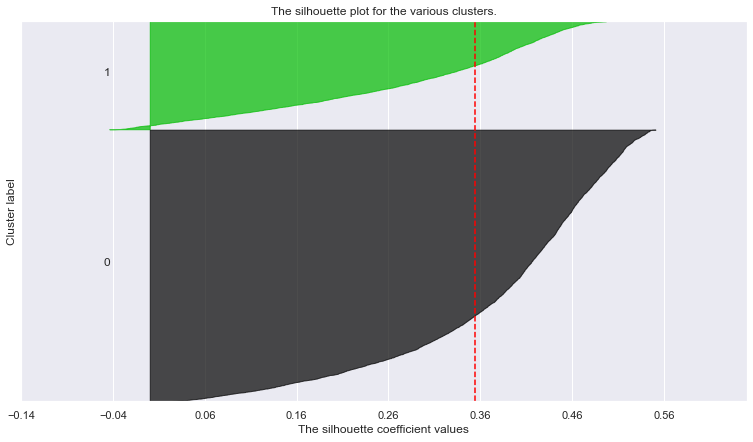

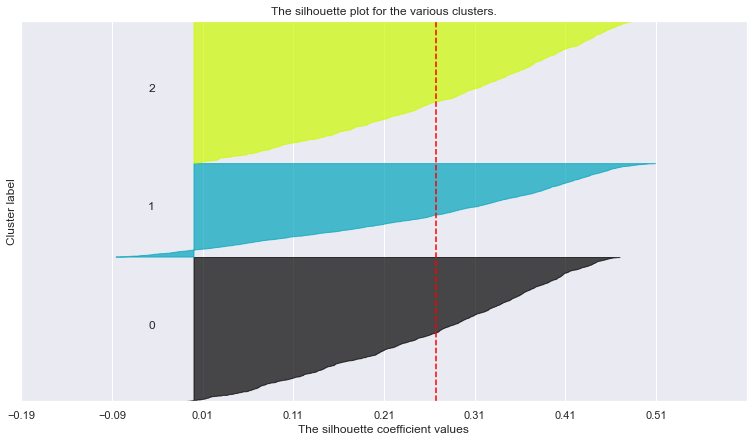

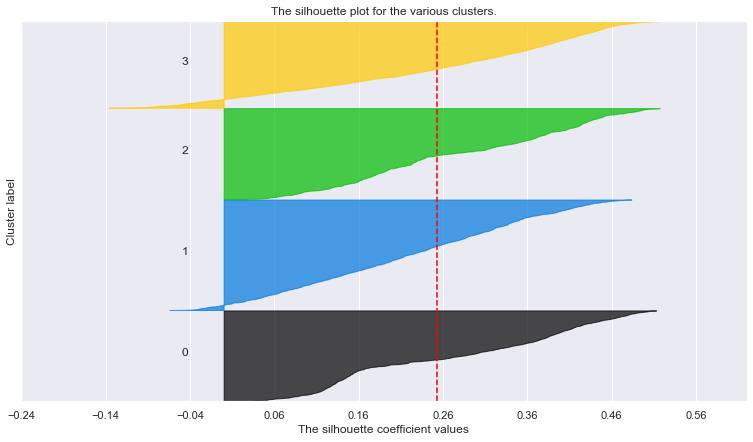

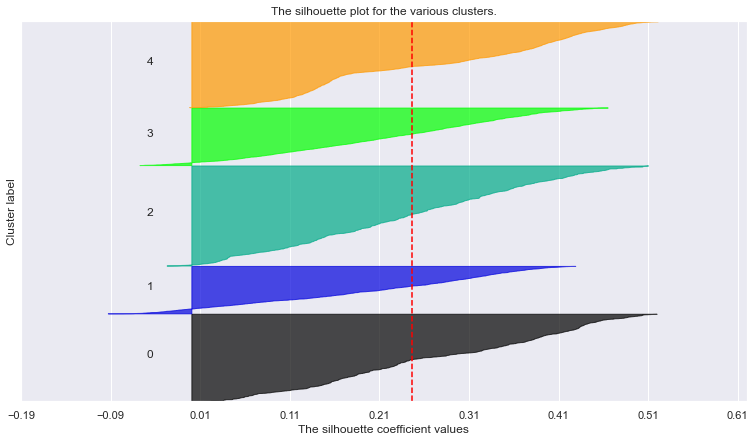

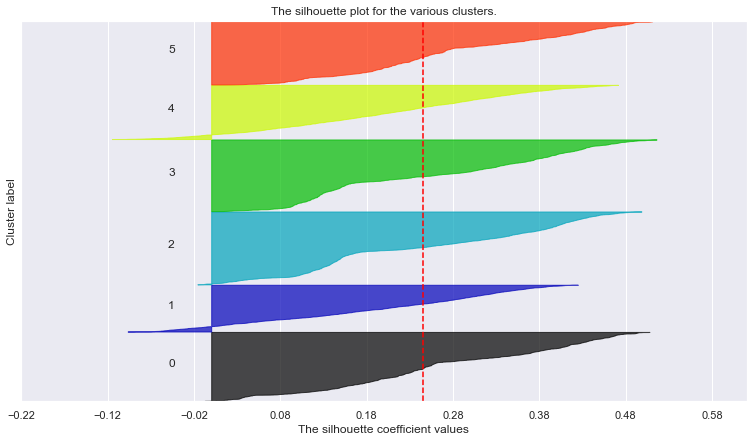

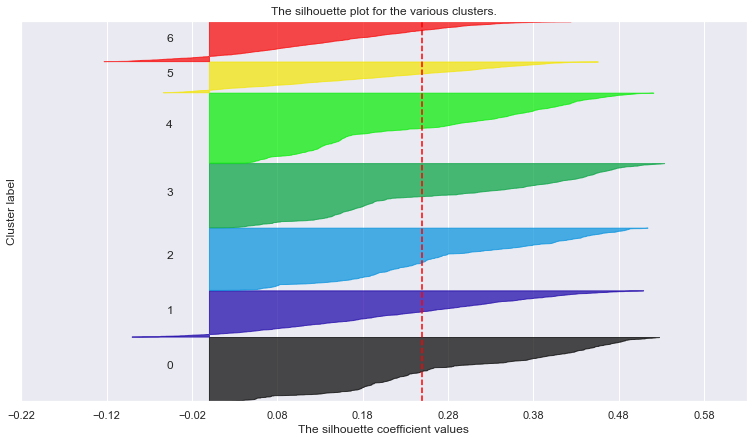

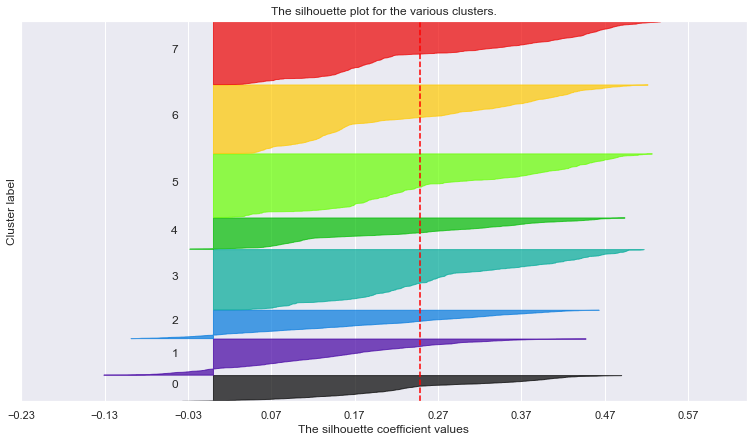

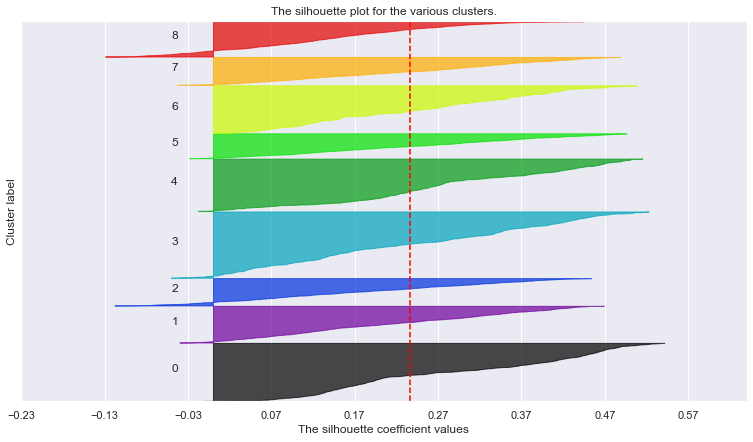

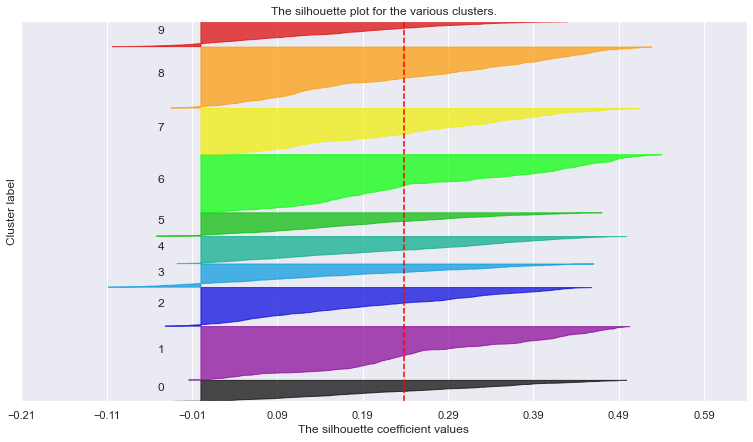

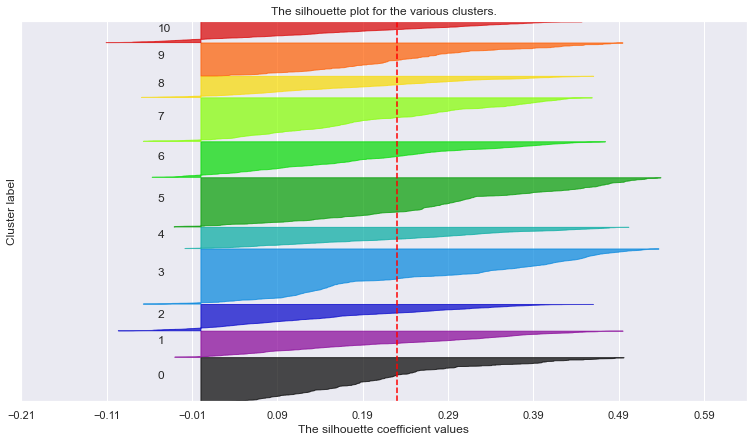

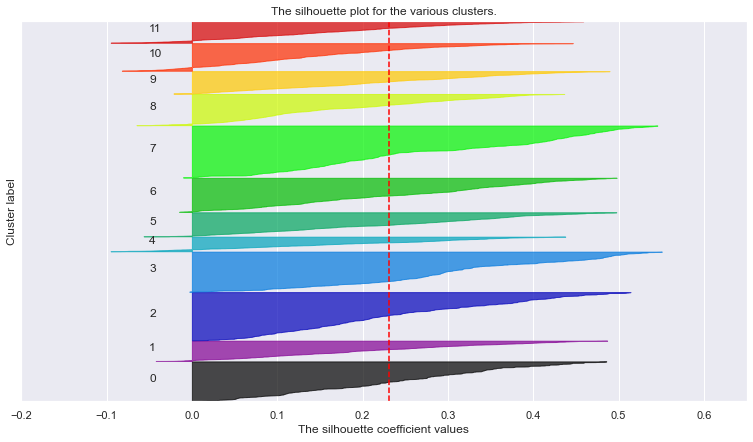

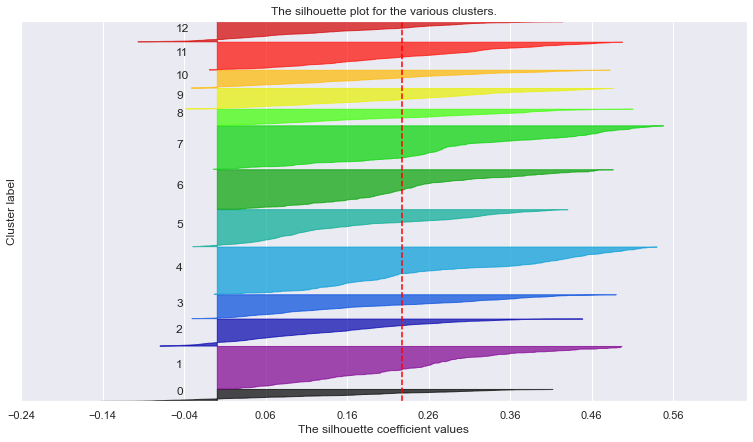

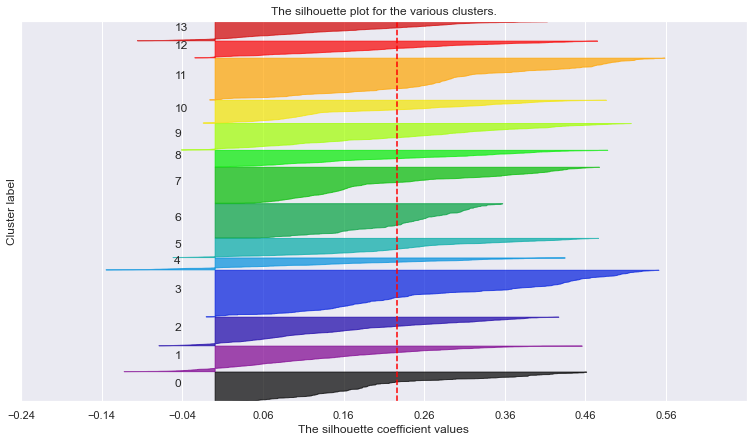

In [42]:
# Storing average silhouette metric
avg_silhouette = []
for nclus in range_clusters:
    # Skip nclus == 1
    if nclus == 1:
        continue
    
    # Create a figure
    fig = plt.figure(figsize=(13, 7))

    # Initialize the KMeans object with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    kmclust = KMeans(n_clusters=nclus, init='k-means++', n_init=15, random_state=1)
    cluster_labels = kmclust.fit_predict(df_val)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed clusters
    silhouette_avg = silhouette_score(df_val, cluster_labels)
    avg_silhouette.append(silhouette_avg)
    print(f"For n_clusters = {nclus}, the average silhouette_score is : {silhouette_avg}")

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(df_val, cluster_labels)

    y_lower = 10
    for i in range(nclus):
        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        
        # Get y_upper to demarcate silhouette y range size
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        # Filling the silhouette
        color = cm.nipy_spectral(float(i) / nclus)
        plt.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    plt.title("The silhouette plot for the various clusters.")
    plt.xlabel("The silhouette coefficient values")
    plt.ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    plt.axvline(x=silhouette_avg, color="red", linestyle="--")
    
    # The silhouette coefficient can range from -1, 1
    xmin, xmax = np.round(sample_silhouette_values.min() -0.1, 2), np.round(sample_silhouette_values.max() + 0.1, 2)
    plt.xlim([xmin, xmax])
    
    # The (nclus+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    plt.ylim([0, len(df_val) + (nclus + 1) * 10])

    plt.yticks([])  # Clear the yaxis labels / ticks
    plt.xticks(np.arange(xmin, xmax, 0.1))

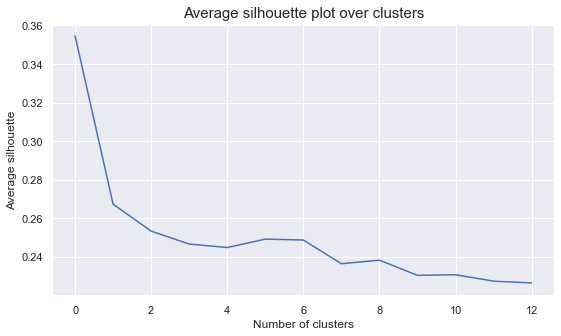

In [43]:
# The average silhouette plot
# The inertia plot
plt.figure(figsize=(9,5))
plt.plot(avg_silhouette)
plt.ylabel("Average silhouette")
plt.xlabel("Number of clusters")
plt.title("Average silhouette plot over clusters", size=15)
plt.show()

#### Preference Features: 

In [44]:
range_clusters = range(1, 15)
inertia = []
for n_clus in range_clusters:  # iterate over desired ncluster range
    kmclust = KMeans(n_clusters=n_clus, init='k-means++', n_init=15, random_state=1)
    kmclust.fit(df_pr)
    inertia.append(kmclust.inertia_)

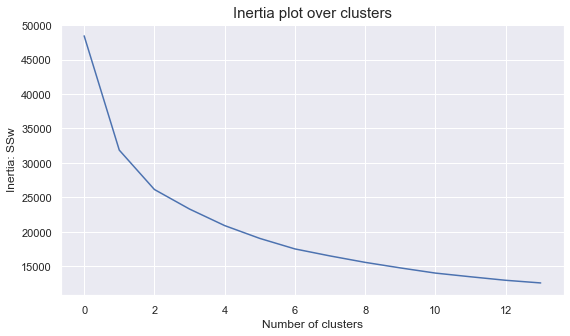

In [45]:
# The inertia plot
plt.figure(figsize=(9,5))
plt.plot(inertia)
#ax.set_xlim(1, 24)
plt.ylabel("Inertia: SSw")
plt.xlabel("Number of clusters")
plt.title("Inertia plot over clusters", size=15)
plt.show()

For n_clusters = 2, the average silhouette_score is : 0.4124802553965853
For n_clusters = 3, the average silhouette_score is : 0.27156791741116665
For n_clusters = 4, the average silhouette_score is : 0.2666203314272807
For n_clusters = 5, the average silhouette_score is : 0.2800729544205576
For n_clusters = 6, the average silhouette_score is : 0.25514851931530086
For n_clusters = 7, the average silhouette_score is : 0.2629069394285012
For n_clusters = 8, the average silhouette_score is : 0.21087211327077401
For n_clusters = 9, the average silhouette_score is : 0.21224523453381328
For n_clusters = 10, the average silhouette_score is : 0.2185787196723972
For n_clusters = 11, the average silhouette_score is : 0.21975689782614735
For n_clusters = 12, the average silhouette_score is : 0.21756577350554837
For n_clusters = 13, the average silhouette_score is : 0.21287588039773664
For n_clusters = 14, the average silhouette_score is : 0.21397313053106337


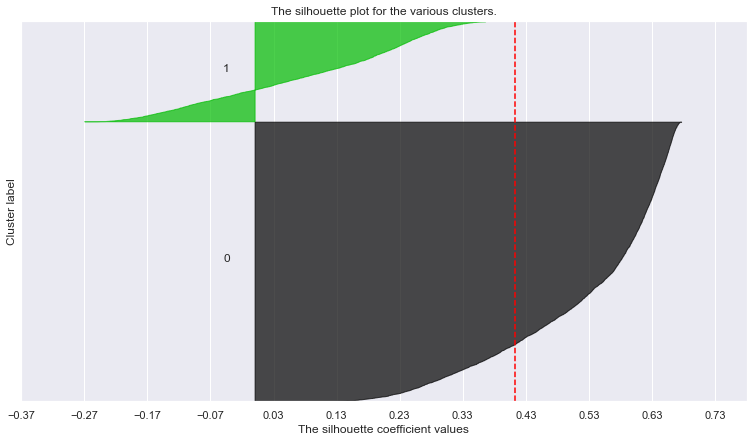

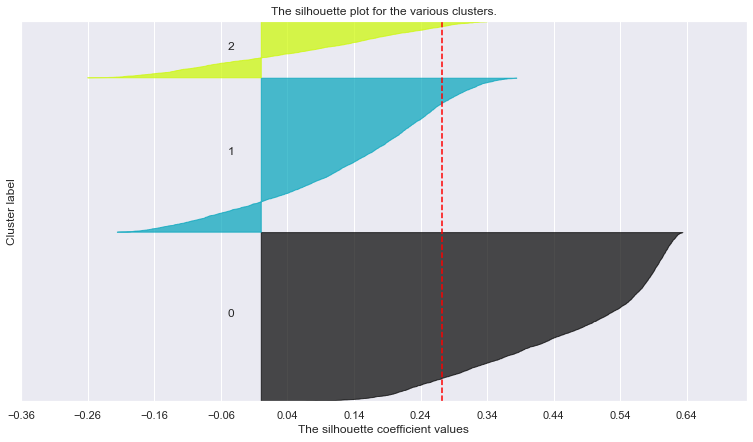

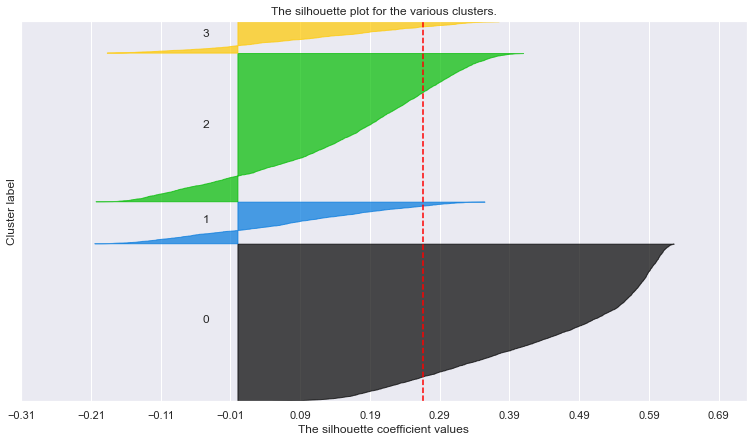

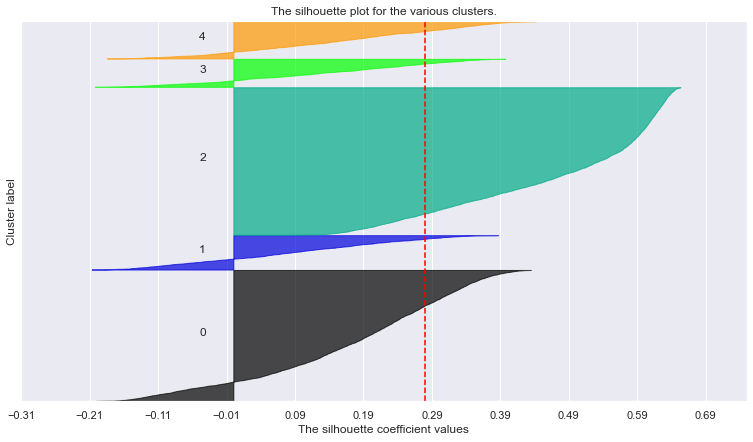

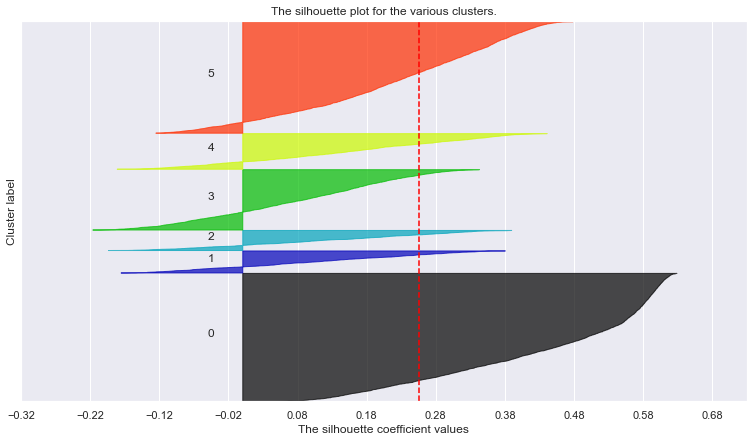

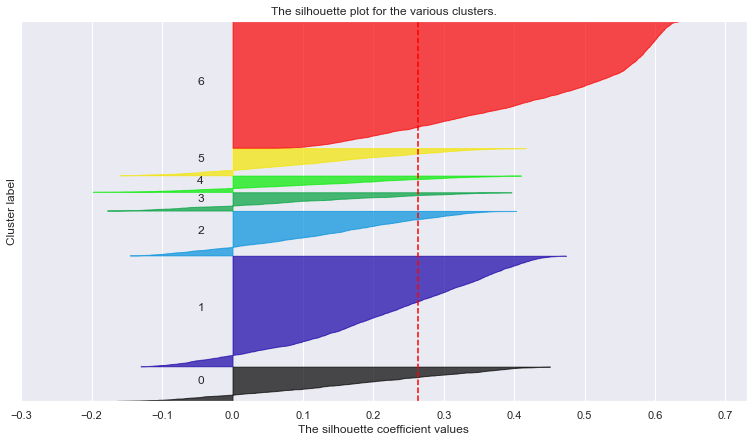

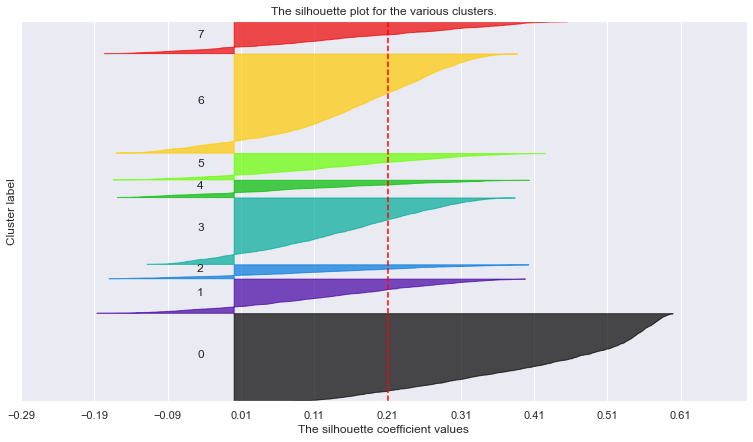

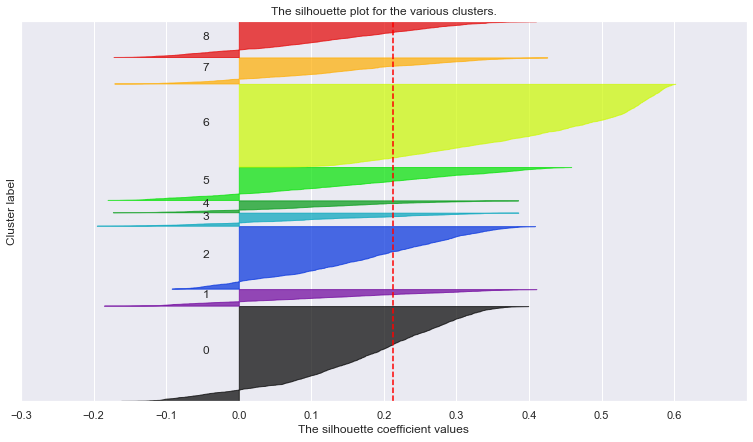

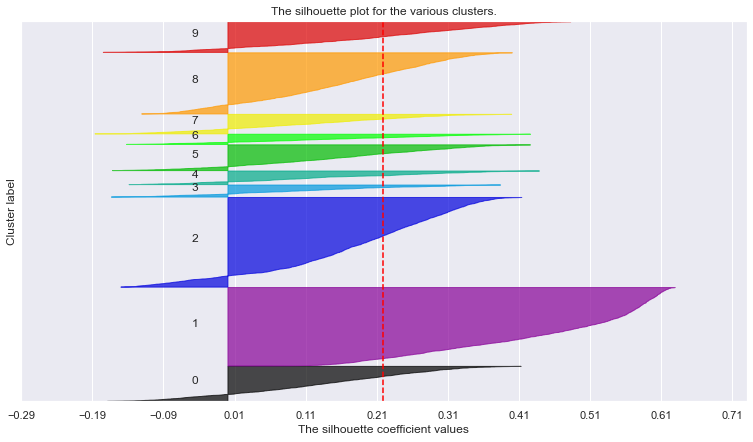

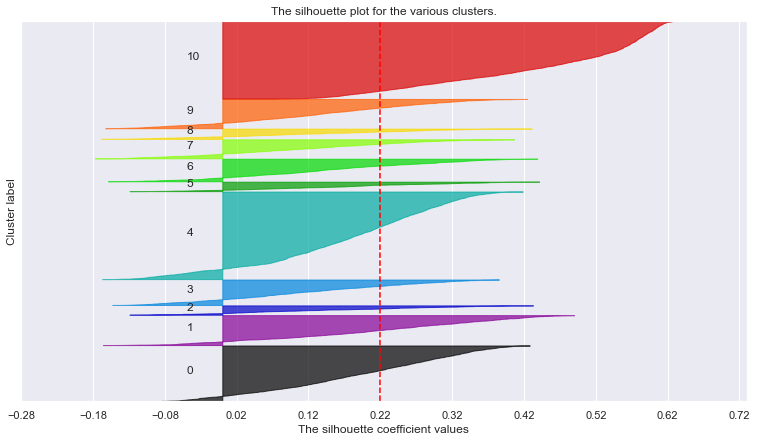

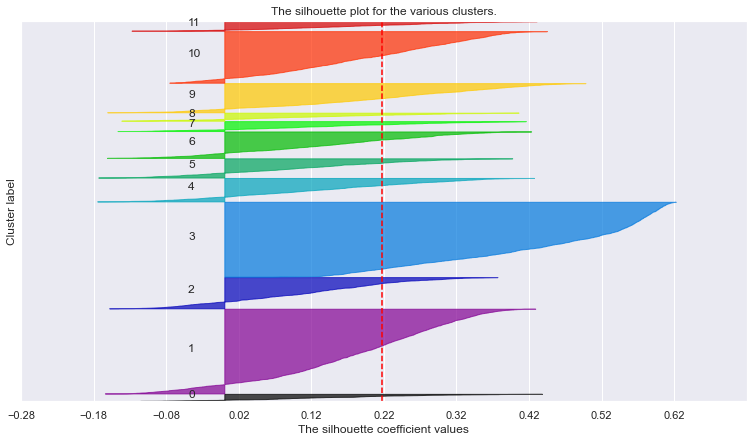

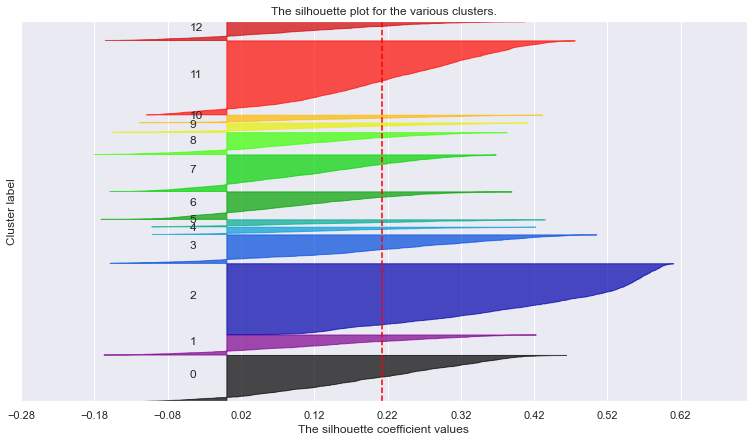

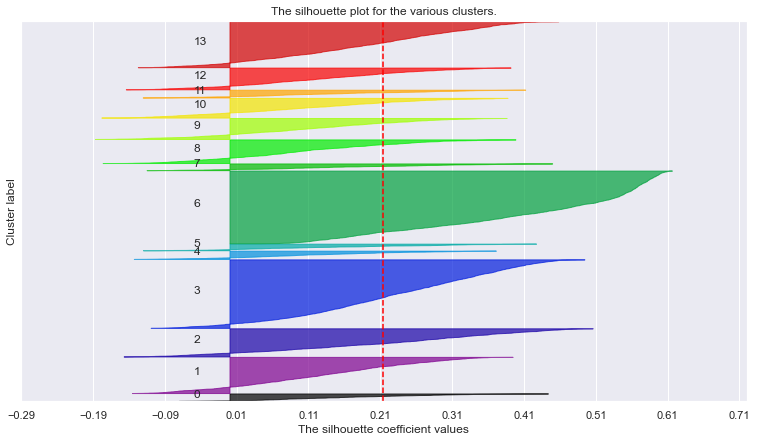

In [46]:
# Storing average silhouette metric
avg_silhouette = []
for nclus in range_clusters:
    # Skip nclus == 1
    if nclus == 1:
        continue
    
    # Create a figure
    fig = plt.figure(figsize=(13, 7))

    # Initialize the KMeans object with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    kmclust = KMeans(n_clusters=nclus, init='k-means++', n_init=15, random_state=1)
    cluster_labels = kmclust.fit_predict(df_pr)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed clusters
    silhouette_avg = silhouette_score(df_pr, cluster_labels)
    avg_silhouette.append(silhouette_avg)
    print(f"For n_clusters = {nclus}, the average silhouette_score is : {silhouette_avg}")

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(df_pr, cluster_labels)

    y_lower = 10
    for i in range(nclus):
        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        
        # Get y_upper to demarcate silhouette y range size
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        # Filling the silhouette
        color = cm.nipy_spectral(float(i) / nclus)
        plt.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    plt.title("The silhouette plot for the various clusters.")
    plt.xlabel("The silhouette coefficient values")
    plt.ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    plt.axvline(x=silhouette_avg, color="red", linestyle="--")
    
    # The silhouette coefficient can range from -1, 1
    xmin, xmax = np.round(sample_silhouette_values.min() -0.1, 2), np.round(sample_silhouette_values.max() + 0.1, 2)
    plt.xlim([xmin, xmax])
    
    # The (nclus+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    plt.ylim([0, len(df_pr) + (nclus + 1) * 10])

    plt.yticks([])  # Clear the yaxis labels / ticks
    plt.xticks(np.arange(xmin, xmax, 0.1))

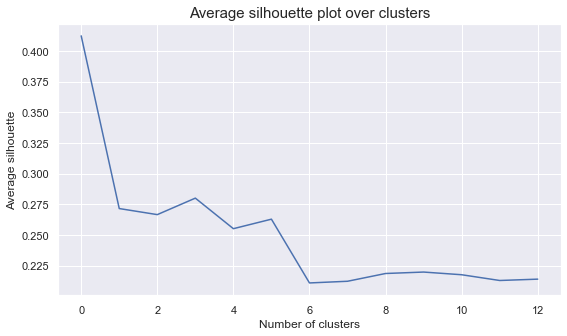

In [47]:
# The average silhouette plot
# The inertia plot
plt.figure(figsize=(9,5))
plt.plot(avg_silhouette)
plt.ylabel("Average silhouette")
plt.xlabel("Number of clusters")
plt.title("Average silhouette plot over clusters", size=15)
plt.show()

In [48]:
# Applying the right clustering (algorithm and number of clusters) for each perspective
kmeans = KMeans(
    n_clusters=3,
    init='k-means++',
    n_init=20,
    random_state=42
)
value_labels = kmeans.fit_predict(df_val)


preference_labels = kmeans.fit_predict(df_pr)


df_norm['value_labels'] = value_labels
df_norm['preference_labels'] = preference_labels

In [49]:
clust=['LTV', 'YearsAsCustomer', 'Edu', 'WebVisit','Dryred','Sweetred','Drywh','Sweetwh','Dessert','Exotic']

In [50]:
pd.concat((df[df.columns[~df.columns.isin(pref)]], pd.Series(value_labels, name='value_labels', 
                                                                   index=df.index.tolist())), 
                               axis=1).groupby('value_labels').mean()

Dayswus        Age        Edu         Income       Freq  \
value_labels                                                                
0             1063.365400  38.915387  16.516303   55746.946106  10.054433   
1              920.278140  68.825449  17.032219  103277.215334  31.220636   
2              721.583934  43.625444  16.811471   62724.866956   8.554692   

                Recency     Monetary         LTV    Perdeal  WebPurchase  \
value_labels                                                               
0             63.071140   363.242253   65.405012  45.451361    52.822689   
1             50.646819  1546.265905  644.900489   2.962887    19.237357   
2             65.478668   287.003853   70.475667  38.424139    46.922016   

              WebVisit  YearsAsCustomer  logIncome    logLTV  FrequencyScore  \
value_labels                                                                   
0             7.028833         2.913662  10.843008  2.177466        2.042576   
1             2.732463         2.522023  11.538284  6.406601        3.833605   
2             5.031026         1.975463  10.969420  2.434798        1.869243   

              RecencyScore  MonetaryScore        RFM  
value_labels                                          
0                 2.499865       2.141741   6.684182  
1                 2.548124       3.861746  10.243475  
2                 2.499471       1.945738   6.314452

In [51]:
globalval_mean=df[df.columns[~df.columns.isin(pref)]].mean()
globalval_mean=globalval_mean.to_frame()
globalval_mean=globalval_mean.transpose()
globalval_mean.rename(index={0:'Global Mean'},inplace=True)
globalval_mean

Dayswus        Age        Edu        Income       Freq  \
Global Mean  898.180777  48.082882  16.755733  70122.442044  14.705224   

               Recency    Monetary         LTV    Perdeal  WebPurchase  \
Global Mean  60.921578  626.067453  210.267686  32.300714    42.296185   

             WebVisit  YearsAsCustomer  logIncome    logLTV  FrequencyScore  \
Global Mean   5.20986         2.460507  11.062544  3.318402        2.418469   

             RecencyScore  MonetaryScore       RFM  
Global Mean      2.511619         2.4915  7.421587

In [52]:
km_val = pd.concat((df[df.columns[~df.columns.isin(pref)]], pd.Series(value_labels, name='value_labels', 
                                                                   index=df.index.tolist())), 
                               axis=1).groupby('value_labels').mean()
pd.concat([km_val, globalval_mean])

Dayswus        Age        Edu         Income       Freq  \
0            1063.365400  38.915387  16.516303   55746.946106  10.054433   
1             920.278140  68.825449  17.032219  103277.215334  31.220636   
2             721.583934  43.625444  16.811471   62724.866956   8.554692   
Global Mean   898.180777  48.082882  16.755733   70122.442044  14.705224   

               Recency     Monetary         LTV    Perdeal  WebPurchase  \
0            63.071140   363.242253   65.405012  45.451361    52.822689   
1            50.646819  1546.265905  644.900489   2.962887    19.237357   
2            65.478668   287.003853   70.475667  38.424139    46.922016   
Global Mean  60.921578   626.067453  210.267686  32.300714    42.296185   

             WebVisit  YearsAsCustomer  logIncome    logLTV  FrequencyScore  \
0            7.028833         2.913662  10.843008  2.177466        2.042576   
1            2.732463         2.522023  11.538284  6.406601        3.833605   
2            5.031026         1.975463  10.969420  2.434798        1.869243   
Global Mean  5.209860         2.460507  11.062544  3.318402        2.418469   

             RecencyScore  MonetaryScore        RFM  
0                2.499865       2.141741   6.684182  
1                2.548124       3.861746  10.243475  
2                2.499471       1.945738   6.314452  
Global Mean      2.511619       2.491500   7.421587

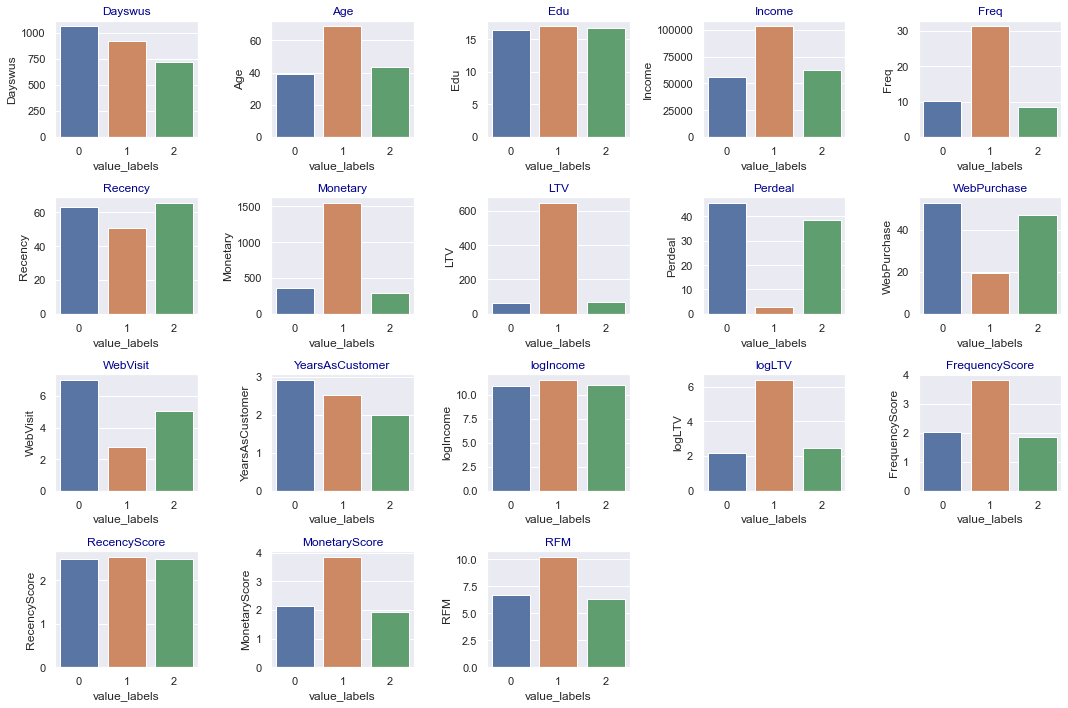

In [53]:
#visualization of the metric features of each cluster 
plt.figure(figsize=(15,10))
for i,j in enumerate(df.columns[~df.columns.isin(pref)]):
    plt.subplot(4,5,i+1)
    sns.barplot(km_val.index,km_val[j])
    plt.title(j,fontdict={'color':'darkblue'})
plt.tight_layout()
plt.show()

In [54]:
def grouped_boxplot(labels, columns):

    # All Numeric Variables' Box Plots in one figure, to be plotted against a non metric feature 
    sns.set()

    # Prepare figure. Create individual axes where each box plot will be placed
    fig, axes = plt.subplots(4, ceil(len(columns) / 4), figsize=(20, 11))

    # Plot data
    # Iterate across axes objects and associate each box plot (hint: use the ax argument):
    for ax, feat in zip(axes.flatten(), columns): # Notice the zip() function and flatten() method
        sns.boxplot(x = df[labels], y = df[feat], ax=ax)

    title = "Variables' Box Plots"
    plt.suptitle(title)
    plt.show()

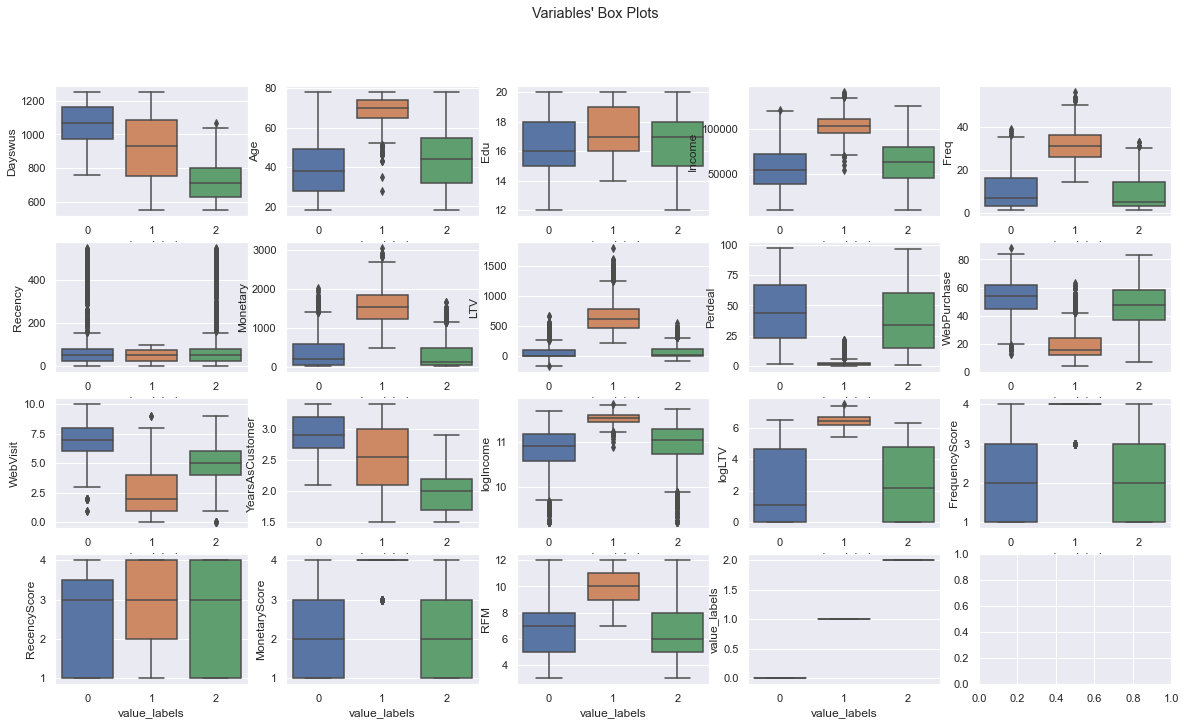

In [55]:
df['value_labels']=value_labels
grouped_boxplot("value_labels", columns=df.columns[~df.columns.isin(pref)] )

In [56]:
df.loc[df['value_labels']==0].describe()

Dayswus          Age          Edu         Income         Freq  \
count  3711.000000  3711.000000  3711.000000    3711.000000  3711.000000   
mean   1063.365400    38.915387    16.516303   55746.946106    10.054433   
std     114.902455    13.041355     1.901394   21064.986214     7.934927   
min     761.000000    18.000000    12.000000   10000.000000     1.000000   
25%     972.000000    28.000000    15.000000   39537.500000     3.000000   
50%    1070.000000    38.000000    16.000000   54825.000000     7.000000   
75%    1162.000000    49.000000    18.000000   72050.000000    16.000000   
max    1249.000000    78.000000    20.000000  121029.000000    39.000000   

           Recency     Monetary          LTV      Perdeal       Dryred  ...  \
count  3711.000000  3711.000000  3711.000000  3711.000000  3711.000000  ...   
mean     63.071140   363.242253    65.405012    45.451361    51.455133  ...   
std      70.269664   385.346734   123.463567    24.980968    25.231330  ...   
min       0.000000     8.000000  -178.000000     2.000000     1.000000  ...   
25%      26.500000    55.000000    -6.000000    23.000000    31.000000  ...   
50%      52.000000   188.000000     3.000000    44.000000    54.000000  ...   
75%      79.000000   596.000000   103.000000    67.000000    73.000000  ...   
max     549.000000  2039.000000   665.000000    97.000000    98.000000  ...   

       WebPurchase     WebVisit  YearsAsCustomer    logIncome       logLTV  \
count  3711.000000  3711.000000      3711.000000  3711.000000  3711.000000   
mean     52.822689     7.028833         2.913662    10.843008     2.177466   
std      12.425360     1.414777         0.315570     0.441258     2.349634   
min      13.000000     1.000000         2.100000     9.210340     0.000000   
25%      45.000000     6.000000         2.700000    10.585005     0.000000   
50%      54.000000     7.000000         2.900000    10.911902     1.098612   
75%      62.000000     8.000000         3.200000    11.185116     4.634729   
max      88.000000    10.000000         3.400000    11.703785     6.499787   

       FrequencyScore  RecencyScore  MonetaryScore          RFM  value_labels  
count     3711.000000   3711.000000    3711.000000  3711.000000        3711.0  
mean         2.042576      2.499865       2.141741     6.684182           0.0  
std          0.935562      1.118546       0.919311     2.194201           0.0  
min          1.000000      1.000000       1.000000     3.000000           0.0  
25%          1.000000      1.000000       1.000000     5.000000           0.0  
50%          2.000000      3.000000       2.000000     7.000000           0.0  
75%          3.000000      3.500000       3.000000     8.000000           0.0  
max          4.000000      4.000000       4.000000    12.000000           0.0  

[8 rows x 25 columns]

In [57]:
df.loc[df['value_labels']==1].describe()

Dayswus          Age          Edu         Income         Freq  \
count  2452.000000  2452.000000  2452.000000    2452.000000  2452.000000   
mean    920.278140    68.825449    17.032219  103277.215334    31.220636   
std     196.644643     6.313750     1.765813   11968.797045     6.793679   
min     550.000000    28.000000    14.000000   54292.000000    14.000000   
25%     754.000000    65.000000    16.000000   95114.500000    26.000000   
50%     930.500000    70.000000    17.000000  103687.000000    31.000000   
75%    1087.250000    74.000000    19.000000  111189.750000    36.000000   
max    1250.000000    78.000000    20.000000  140628.000000    56.000000   

           Recency     Monetary          LTV      Perdeal       Dryred  ...  \
count  2452.000000  2452.000000  2452.000000  2452.000000  2452.000000  ...   
mean     50.646819  1546.265905   644.900489     2.962887    45.976754  ...   
std      28.920946   430.840590   233.342896     3.144139    18.179010  ...   
min       0.000000   493.000000   218.000000     0.000000     6.000000  ...   
25%      25.000000  1218.000000   467.000000     1.000000    32.000000  ...   
50%      52.000000  1529.000000   604.000000     2.000000    45.000000  ...   
75%      75.250000  1852.000000   781.250000     3.000000    59.000000  ...   
max     100.000000  3052.000000  1791.000000    22.000000    97.000000  ...   

       WebPurchase     WebVisit  YearsAsCustomer    logIncome       logLTV  \
count  2452.000000  2452.000000      2452.000000  2452.000000  2452.000000   
mean     19.237357     2.732463         2.522023    11.538284     6.406601   
std      10.168709     1.670354         0.540642     0.118379     0.353523   
min       4.000000     0.000000         1.500000    10.902132     5.384495   
25%      12.000000     1.000000         2.100000    11.462837     6.146329   
50%      16.000000     2.000000         2.550000    11.549132     6.403574   
75%      24.000000     4.000000         3.000000    11.618993     6.660895   
max      63.000000     9.000000         3.400000    11.853873     7.490529   

       FrequencyScore  RecencyScore  MonetaryScore          RFM  value_labels  
count     2452.000000   2452.000000    2452.000000  2452.000000        2452.0  
mean         3.833605      2.548124       3.861746    10.243475           1.0  
std          0.372511      1.098815       0.345237     1.292044           0.0  
min          3.000000      1.000000       3.000000     7.000000           1.0  
25%          4.000000      2.000000       4.000000     9.000000           1.0  
50%          4.000000      3.000000       4.000000    10.000000           1.0  
75%          4.000000      4.000000       4.000000    11.000000           1.0  
max          4.000000      4.000000       4.000000    12.000000           1.0  

[8 rows x 25 columns]

In [58]:
df.loc[df['value_labels']==2].describe()

Dayswus          Age          Edu         Income         Freq  \
count  3778.000000  3778.000000  3778.000000    3778.000000  3778.000000   
mean    721.583934    43.625444    16.811471   62724.866956     8.554692   
std     107.020804    14.355139     1.867308   22224.215614     6.967045   
min     550.000000    18.000000    12.000000   10000.000000     1.000000   
25%     632.000000    32.000000    15.000000   45787.250000     3.000000   
50%     714.000000    44.000000    17.000000   63505.000000     5.000000   
75%     803.000000    55.000000    18.000000   80227.000000    14.000000   
max    1067.000000    78.000000    20.000000  125962.000000    33.000000   

           Recency     Monetary          LTV      Perdeal       Dryred  ...  \
count  3778.000000  3778.000000  3778.000000  3778.000000  3778.000000  ...   
mean     65.478668   287.003853    70.475667    38.424139    52.823288  ...   
std      77.802071   322.624513   108.914683    25.741797    23.888574  ...   
min       0.000000     6.000000   -86.000000     1.000000     1.000000  ...   
25%      26.000000    41.000000    -2.000000    15.000000    35.000000  ...   
50%      52.000000   120.000000     9.000000    34.000000    55.000000  ...   
75%      80.000000   483.000000   120.000000    60.000000    72.000000  ...   
max     549.000000  1670.000000   551.000000    96.000000    99.000000  ...   

       WebPurchase     WebVisit  YearsAsCustomer    logIncome       logLTV  \
count  3778.000000  3778.000000      3778.000000  3778.000000  3778.000000   
mean     46.922016     5.031026         1.975463    10.969420     2.434798   
std      14.460123     1.806455         0.294030     0.421100     2.295822   
min       7.000000     0.000000         1.500000     9.210340     0.000000   
25%      37.000000     4.000000         1.700000    10.731761     0.000000   
50%      48.000000     5.000000         2.000000    11.058874     2.197225   
75%      58.000000     6.000000         2.200000    11.292615     4.787492   
max      83.000000     9.000000         2.900000    11.743736     6.311735   

       FrequencyScore  RecencyScore  MonetaryScore          RFM  value_labels  
count     3778.000000   3778.000000    3778.000000  3778.000000        3778.0  
mean         1.869243      2.499471       1.945738     6.314452           2.0  
std          0.874643      1.132066       0.884646     2.156102           0.0  
min          1.000000      1.000000       1.000000     3.000000           2.0  
25%          1.000000      1.000000       1.000000     5.000000           2.0  
50%          2.000000      3.000000       2.000000     6.000000           2.0  
75%          3.000000      4.000000       3.000000     8.000000           2.0  
max          4.000000      4.000000       4.000000    12.000000           2.0  

[8 rows x 25 columns]

In [59]:
km_pref = pd.concat((df[pref], pd.Series(preference_labels, name='preference_labels', 
                                                                   index=df.index.tolist())), 
                               axis=1)
km_pref=km_pref.groupby('preference_labels').mean()
km_pref

Dryred   Sweetred      Drywh    Sweetwh    Dessert  \
preference_labels                                                          
0                  72.230075   2.408444  20.603071   2.397155   2.310454   
1                  18.442935  17.574728  27.055707  18.358696  18.562500   
2                  38.662471   8.073776  37.865723   7.867096   7.529690   

                      Exotic  
preference_labels             
0                  11.412057  
1                  37.885190  
2                  13.985036

In [60]:
globalpref_mean=df[pref].mean()
globalpref_mean=globalpref_mean.to_frame()
globalpref_mean=globalpref_mean.transpose()
globalpref_mean.rename(index={0:'Global Mean'},inplace=True)
globalpref_mean

Dryred  Sweetred      Drywh  Sweetwh   Dessert     Exotic
Global Mean  50.623819  6.956549  28.574039  6.98361  6.838039  16.377683

In [61]:
pd.concat([km_pref, globalpref_mean])

Dryred   Sweetred      Drywh    Sweetwh    Dessert     Exotic
0            72.230075   2.408444  20.603071   2.397155   2.310454  11.412057
1            18.442935  17.574728  27.055707  18.358696  18.562500  37.885190
2            38.662471   8.073776  37.865723   7.867096   7.529690  13.985036
Global Mean  50.623819   6.956549  28.574039   6.983610   6.838039  16.377683

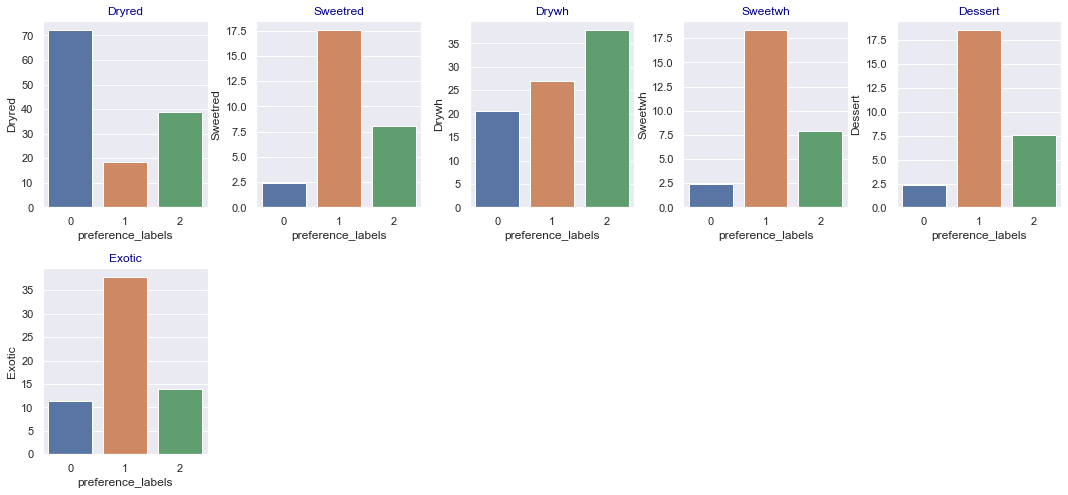

In [62]:
#visualization of the metric features of each cluster 
plt.figure(figsize=(15,10))
for i,j in enumerate(pref):
    plt.subplot(3,5,i+1)
    sns.barplot(km_pref.index,km_pref[j])
    plt.title(j,fontdict={'color':'darkblue'})
plt.tight_layout()
plt.show()

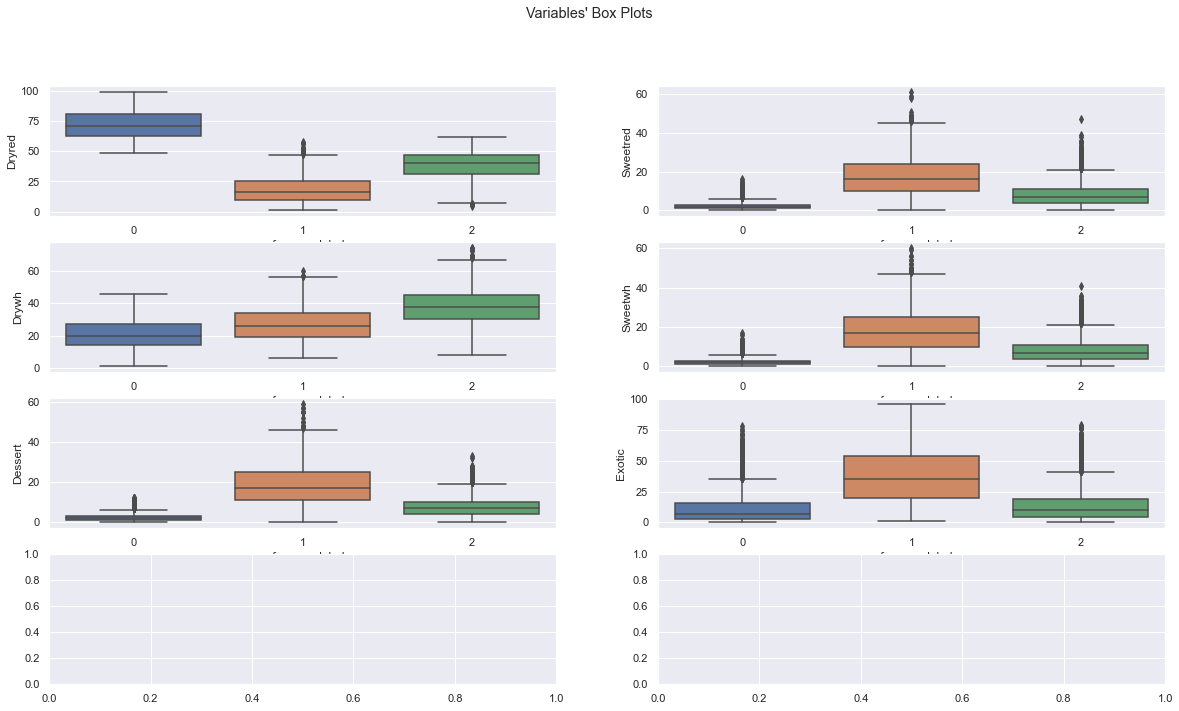

In [63]:
df['preference_labels']=preference_labels
grouped_boxplot("preference_labels", pref )

In [64]:
df['preference_labels']=preference_labels
df[pref].loc[df['preference_labels']==0].describe()

Dryred     Sweetred        Drywh      Sweetwh      Dessert  \
count  4429.000000  4429.000000  4429.000000  4429.000000  4429.000000   
mean     72.230075     2.408444    20.603071     2.397155     2.310454   
std      11.209637     2.319944     8.789958     2.314598     2.185406   
min      49.000000     0.000000     1.000000     0.000000     0.000000   
25%      63.000000     1.000000    14.000000     1.000000     1.000000   
50%      71.000000     2.000000    20.000000     2.000000     2.000000   
75%      81.000000     3.000000    27.000000     3.000000     3.000000   
max      99.000000    16.000000    46.000000    17.000000    12.000000   

            Exotic  
count  4429.000000  
mean     11.412057  
std      11.886745  
min       0.000000  
25%       3.000000  
50%       7.000000  
75%      16.000000  
max      78.000000

In [65]:
df[pref].loc[df['preference_labels']==1].describe()

Dryred     Sweetred        Drywh      Sweetwh      Dessert  \
count  1472.000000  1472.000000  1472.000000  1472.000000  1472.000000   
mean     18.442935    17.574728    27.055707    18.358696    18.562500   
std      11.103040    10.312908     9.971524    10.956642    10.453817   
min       1.000000     0.000000     6.000000     0.000000     0.000000   
25%      10.000000    10.000000    19.000000    10.000000    11.000000   
50%      16.000000    16.000000    26.000000    17.000000    17.000000   
75%      25.000000    24.000000    34.000000    25.000000    25.000000   
max      58.000000    61.000000    60.000000    60.000000    59.000000   

            Exotic  
count  1472.000000  
mean     37.885190  
std      22.399585  
min       1.000000  
25%      20.000000  
50%      35.000000  
75%      54.000000  
max      96.000000

In [66]:
df[pref].loc[df['preference_labels']==2].describe()

Dryred     Sweetred        Drywh      Sweetwh      Dessert  \
count  4040.000000  4040.000000  4040.000000  4040.000000  4040.000000   
mean     38.662471     8.073776    37.865723     7.867096     7.529690   
std      11.051168     5.881766    10.557146     5.582652     5.029216   
min       5.000000     0.000000     8.000000     0.000000     0.000000   
25%      31.000000     4.000000    30.000000     4.000000     4.000000   
50%      40.000000     7.000000    38.000000     7.000000     7.000000   
75%      47.000000    11.000000    45.000000    11.000000    10.000000   
max      62.000000    47.000000    74.000000    41.000000    33.000000   

            Exotic  
count  4040.000000  
mean     13.985036  
std      13.270964  
min       0.000000  
25%       4.000000  
50%      10.000000  
75%      19.000000  
max      79.000000

### Merge

In [67]:
df_centroids = df.groupby(['value_labels', 'preference_labels'])\
    [clust].mean()
df_centroids

LTV  YearsAsCustomer        Edu  \
value_labels preference_labels                                           
0            0                   95.284585         2.923320  17.345567   
             1                   18.149725         2.890797  14.657967   
             2                   50.128713         2.913284  16.420792   
1            0                  652.757946         2.552445  18.020782   
             1                  597.301471         2.533824  14.977941   
             2                  644.931242         2.504339  16.678905   
2            0                   82.925000         1.989728  17.638043   
             1                   26.605263         1.928783  14.972039   
             2                   73.307572         1.977068  16.508826   

                                WebVisit     Dryred   Sweetred      Drywh  \
value_labels preference_labels                                              
0            0                  7.028797  73.672501   2.249012  19.665726   
             1                  7.086538  17.571429  18.037088  26.960165   
             2                  6.994224  39.343234   7.785479  37.719472   
1            0                  3.570905  66.591687   2.863081  24.896088   
             1                  2.117647  21.669118  15.963235  27.654412   
             2                  2.330441  36.926569   8.028705  39.708945   
2            0                  5.163587  73.348370   2.359783  19.596739   
             1                  5.274671  18.764803  17.381579  27.036184   
             2                  4.736253  39.997280   8.387259  35.922948   

                                  Sweetwh    Dessert     Exotic  
value_labels preference_labels                                   
0            0                   2.193111   2.158667  13.557312  
             1                  18.817308  18.607143  40.420330  
             2                   7.696370   7.458746  19.093234  
1            0                   2.911980   2.709046   5.405868  
             1                  16.919118  17.808824  19.500000  
             2                   7.845127   7.474633   7.740320  
2            0                   2.364674   2.279348  12.017391  
             1                  18.131579  18.677632  38.962171  
             2                   8.047421   7.656351  16.363569

In [68]:
# Centroids of the concatenated cluster labels
df_centroids = df_norm.groupby(['value_labels', 'preference_labels'])\
    [clust].mean()
df_centroids

LTV  YearsAsCustomer       Edu  WebVisit  \
value_labels preference_labels                                                  
0            0                  0.098599         0.581467  0.115189  0.257199   
             1                 -0.111006         0.545330 -0.780678  0.271635   
             2                 -0.024107         0.570315 -0.193069  0.248556   
1            0                  1.613473         0.169383  0.340261 -0.607274   
             1                  1.462776         0.148693 -0.674020 -0.970588   
             2                  1.592204         0.115932 -0.107032 -0.917390   
2            0                  0.065014        -0.455857  0.212681 -0.209103   
             1                 -0.088029        -0.523575 -0.675987 -0.181332   
             2                  0.038879        -0.469925 -0.163725 -0.315937   

                                  Dryred  Sweetred     Drywh   Sweetwh  \
value_labels preference_labels                                           
0            0                  0.629792 -0.218874 -0.463015 -0.225861   
             1                 -0.928571  1.754636 -0.057769  1.852163   
             2                 -0.323799  0.473185  0.539971  0.462046   
1            0                  0.433102 -0.142115 -0.172440 -0.136002   
             1                 -0.814747  1.495404 -0.019199  1.614890   
             2                 -0.390929  0.503588  0.650497  0.480641   
2            0                  0.620788 -0.205027 -0.466848 -0.204416   
             1                 -0.895422  1.672697 -0.053545  1.766447   
             2                 -0.305631  0.548407  0.440164  0.505928   

                                 Dessert    Exotic  
value_labels preference_labels                      
0            0                 -0.263048  0.197628  
             1                  2.086735  1.690018  
             2                  0.494107  0.505180  
1            0                 -0.184422 -0.255230  
             1                  1.972689  0.527778  
             2                  0.496376 -0.125538  
2            0                 -0.245807  0.112077  
             1                  2.096805  1.609010  
             2                  0.522336  0.353532

In [69]:
# Using Hierarchical clustering to merge the concatenated cluster centroids
linkage='ward'
distance='euclidean'
hclust = AgglomerativeClustering(
    linkage=linkage, 
    affinity=distance, 
    distance_threshold=0, 
    n_clusters=None
)
hclust_labels = hclust.fit_predict(df_centroids)

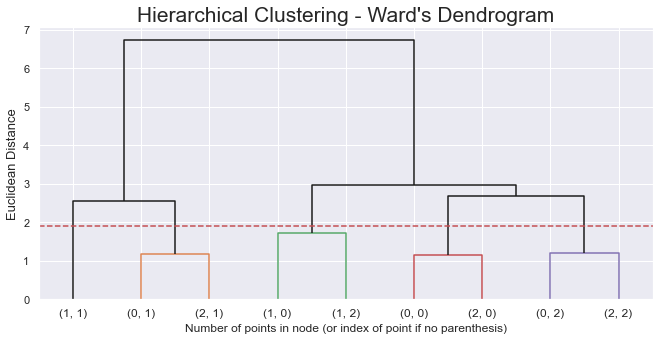

In [70]:
# create the counts of samples under each node (number of points being merged)
counts = np.zeros(hclust.children_.shape[0])
n_samples = len(hclust.labels_)

# hclust.children_ contains the observation ids that are being merged together
# At the i-th iteration, children[i][0] and children[i][1] are merged to form node n_samples + i
for i, merge in enumerate(hclust.children_):
    # track the number of observations in the current cluster being formed
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            # If this is True, then we are merging an observation
            current_count += 1  # leaf node
        else:
            # Otherwise, we are merging a previously formed cluster
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count

# the hclust.children_ is used to indicate the two points/clusters being merged (dendrogram's u-joins)
# the hclust.distances_ indicates the distance between the two points/clusters (height of the u-joins)
# the counts indicate the number of points being merged (dendrogram's x-axis)
linkage_matrix = np.column_stack(
    [hclust.children_, hclust.distances_, counts]
).astype(float)

# Plot the corresponding dendrogram
sns.set()
fig = plt.figure(figsize=(11,5))
# The Dendrogram parameters need to be tuned
y_threshold = 1.9
dendrogram(linkage_matrix, truncate_mode='level', labels=df_centroids.index, p=5, color_threshold=y_threshold, above_threshold_color='k')
plt.hlines(y_threshold, 0, 1000, colors="r", linestyles="dashed")
plt.title(f'Hierarchical Clustering - {linkage.title()}\'s Dendrogram', fontsize=21)
plt.xlabel('Number of points in node (or index of point if no parenthesis)')
plt.ylabel(f'Euclidean Distance', fontsize=13)
plt.show()

In [71]:
# Re-running the Hierarchical clustering based on the correct number of clusters
hclust = AgglomerativeClustering(
    linkage='ward', 
    affinity='euclidean', 
    n_clusters=4
)
hclust_labels = hclust.fit_predict(df_centroids)
df_centroids['hclust_labels'] = hclust_labels

df_centroids  # centroid's cluster labels

LTV  YearsAsCustomer       Edu  WebVisit  \
value_labels preference_labels                                                  
0            0                  0.098599         0.581467  0.115189  0.257199   
             1                 -0.111006         0.545330 -0.780678  0.271635   
             2                 -0.024107         0.570315 -0.193069  0.248556   
1            0                  1.613473         0.169383  0.340261 -0.607274   
             1                  1.462776         0.148693 -0.674020 -0.970588   
             2                  1.592204         0.115932 -0.107032 -0.917390   
2            0                  0.065014        -0.455857  0.212681 -0.209103   
             1                 -0.088029        -0.523575 -0.675987 -0.181332   
             2                  0.038879        -0.469925 -0.163725 -0.315937   

                                  Dryred  Sweetred     Drywh   Sweetwh  \
value_labels preference_labels                                           
0            0                  0.629792 -0.218874 -0.463015 -0.225861   
             1                 -0.928571  1.754636 -0.057769  1.852163   
             2                 -0.323799  0.473185  0.539971  0.462046   
1            0                  0.433102 -0.142115 -0.172440 -0.136002   
             1                 -0.814747  1.495404 -0.019199  1.614890   
             2                 -0.390929  0.503588  0.650497  0.480641   
2            0                  0.620788 -0.205027 -0.466848 -0.204416   
             1                 -0.895422  1.672697 -0.053545  1.766447   
             2                 -0.305631  0.548407  0.440164  0.505928   

                                 Dessert    Exotic  hclust_labels  
value_labels preference_labels                                     
0            0                 -0.263048  0.197628              3  
             1                  2.086735  1.690018              0  
             2                  0.494107  0.505180              1  
1            0                 -0.184422 -0.255230              2  
             1                  1.972689  0.527778              0  
             2                  0.496376 -0.125538              2  
2            0                 -0.245807  0.112077              3  
             1                  2.096805  1.609010              0  
             2                  0.522336  0.353532              1

In [72]:
# Mapper between concatenated clusters and hierarchical clusters
cluster_mapper = df_centroids['hclust_labels'].to_dict()

df_ = df_norm.copy()

# Mapping the hierarchical clusters on the centroids to the observations
df_['merged_labels'] = df_.apply(
    lambda row: cluster_mapper[
        (row['value_labels'], row['preference_labels'])
    ], axis=1
)

# Merged cluster centroids
df_.groupby('merged_labels').mean()[clust]

LTV  YearsAsCustomer       Edu  WebVisit    Dryred  \
merged_labels                                                            
0              0.043888         0.067180 -0.727582 -0.030231 -0.904363   
1              0.008848         0.026051 -0.177716 -0.046792 -0.314293   
2              1.599716         0.134811  0.050950 -0.807858 -0.099885   
3              0.081486         0.052894  0.164867  0.019593  0.625204   

               Sweetred     Drywh   Sweetwh   Dessert    Exotic  
merged_labels                                                    
0              1.696841 -0.052461  1.794837  2.080357  1.549177  
1              0.512542  0.487751  0.485005  0.508876  0.425836  
2              0.275529  0.359840  0.262845  0.255922 -0.171344  
3             -0.211818 -0.464968 -0.214934 -0.254263  0.154036

In [73]:
df['merged_labels']=df_['merged_labels']

In [74]:
var=df.columns[~df.columns.isin(['value_labels', 'preference_labels', 'merged_labels'])]

In [75]:
var=list(var)

In [76]:
final= df[var + ['merged_labels']].groupby('merged_labels').mean().T
final

merged_labels               0             1              2             3
Dayswus            897.798913    884.773840     920.063040    893.739684
Age                 31.718750     40.436242      68.829447     46.830241
Edu                 14.817255     16.466853      17.152850     17.494600
Income           45838.358696  57698.534759  103196.553972  67554.759900
Freq                 7.467391      8.476644      31.322539     11.382443
Recency             67.601902     67.203150      50.642919     60.368873
Monetary           257.113451    287.873546    1552.705095    420.223207
LTV                 75.150815     62.256126     647.695596     88.986707
Perdeal             46.212636     42.770809       2.981434     38.063694
Dryred              18.442935     39.685438      47.404145     73.507339
Sweetred            17.574728      8.100336       6.204231      2.305456
Drywh               27.055707     36.779513      34.477116     19.630573
Sweetwh             18.358696      7.880043       6.102763      2.280532
Dessert             18.562500      7.562135       5.791451      2.220161
Exotic              37.885190     17.665046       6.915803     12.772639
WebPurchase         50.277174     48.995427      19.353195     49.041817
WebVisit             5.879076      5.812831       2.768566      6.078372
YearsAsCustomer      2.460462      2.423446       2.521330      2.447605
logIncome           10.571262     10.882185      11.537369     11.085236
logLTV               1.611064      2.126944       6.410741      2.869781
FrequencyScore       1.657609      1.854052       3.838515      2.215176
RecencyScore         2.495245      2.474430       2.545769      2.522570
MonetaryScore        1.701766      1.942958       3.864853      2.318748
RFM                  5.854620      6.271440      10.249136      7.056494

In [77]:
global_mean=df[var].mean()
global_mean=global_mean.to_frame()
global_mean.rename(columns={0:'Global Mean'},inplace=True)

In [78]:
pd.concat([final, global_mean], axis=1)

0             1              2             3  \
Dayswus            897.798913    884.773840     920.063040    893.739684   
Age                 31.718750     40.436242      68.829447     46.830241   
Edu                 14.817255     16.466853      17.152850     17.494600   
Income           45838.358696  57698.534759  103196.553972  67554.759900   
Freq                 7.467391      8.476644      31.322539     11.382443   
Recency             67.601902     67.203150      50.642919     60.368873   
Monetary           257.113451    287.873546    1552.705095    420.223207   
LTV                 75.150815     62.256126     647.695596     88.986707   
Perdeal             46.212636     42.770809       2.981434     38.063694   
Dryred              18.442935     39.685438      47.404145     73.507339   
Sweetred            17.574728      8.100336       6.204231      2.305456   
Drywh               27.055707     36.779513      34.477116     19.630573   
Sweetwh             18.358696      7.880043       6.102763      2.280532   
Dessert             18.562500      7.562135       5.791451      2.220161   
Exotic              37.885190     17.665046       6.915803     12.772639   
WebPurchase         50.277174     48.995427      19.353195     49.041817   
WebVisit             5.879076      5.812831       2.768566      6.078372   
YearsAsCustomer      2.460462      2.423446       2.521330      2.447605   
logIncome           10.571262     10.882185      11.537369     11.085236   
logLTV               1.611064      2.126944       6.410741      2.869781   
FrequencyScore       1.657609      1.854052       3.838515      2.215176   
RecencyScore         2.495245      2.474430       2.545769      2.522570   
MonetaryScore        1.701766      1.942958       3.864853      2.318748   
RFM                  5.854620      6.271440      10.249136      7.056494   

                  Global Mean  
Dayswus            898.180777  
Age                 48.082882  
Edu                 16.755733  
Income           70122.442044  
Freq                14.705224  
Recency             60.921578  
Monetary           626.067453  
LTV                210.267686  
Perdeal             32.300714  
Dryred              50.623819  
Sweetred             6.956549  
Drywh               28.574039  
Sweetwh              6.983610  
Dessert              6.838039  
Exotic              16.377683  
WebPurchase         42.296185  
WebVisit             5.209860  
YearsAsCustomer      2.460507  
logIncome           11.062544  
logLTV               3.318402  
FrequencyScore       2.418469  
RecencyScore         2.511619  
MonetaryScore        2.491500  
RFM                  7.421587

In [79]:
# Setting df to have the final product, behavior and merged clusters
df_final = df_.copy()

In [80]:
# using R²
def get_ss(df):
    ss = np.sum(df.var() * (df.count() - 1))
    return ss  # return sum of sum of squares of each df variable

sst = get_ss(df_final[clust])  # get total sum of squares
ssw_labels = df_final[clust + ["merged_labels"]].groupby(by='merged_labels').apply(get_ss)  # compute ssw for each cluster labels
ssb = sst - np.sum(ssw_labels) 
r2 = ssb / sst
r2

0.42199105668201

In [81]:
df_out_norm.head()

Dayswus       Age       Edu    Income  Freq   Recency  Monetary  \
Custid                                                                      
4324.0  -0.068571 -0.933333 -1.000000 -0.946607 -0.55  3.673077 -0.366864   
5005.0  -0.462857 -0.866667 -0.333333 -0.975124 -0.55  3.692308 -0.370809   
3950.0   0.088571 -0.966667 -1.333333 -0.693797 -0.55  7.076923 -0.368836   
5642.0  -0.885714 -0.966667 -1.333333 -0.917954 -0.55  7.365385 -0.365878   
10969.0  0.380000 -0.900000 -0.666667 -0.789909 -0.40 -0.923077 -0.309665   

              LTV  Perdeal    Dryred  ...    Exotic  WebPurchase  WebVisit  \
Custid                                ...                                    
4324.0  -0.163043     0.74 -1.222222  ...  2.111111    -0.033333     -0.50   
5005.0  -0.165761     1.12 -1.111111  ...  1.111111     0.633333     -0.25   
3950.0  -0.176630     1.36 -1.111111  ...  4.500000    -0.200000     -0.25   
5642.0  -0.157609     0.28 -1.111111  ...  3.222222    -0.266667     -0.50   
10969.0 -0.141304     0.08 -1.166667  ...  2.944444     1.166667      0.75   

         YearsAsCustomer  logIncome    logLTV  FrequencyScore  RecencyScore  \
Custid                                                                        
4324.0          0.000000  -1.387731 -0.690800            -0.5          -1.0   
5005.0         -0.444444  -1.457320 -0.690800            -0.5          -1.0   
3950.0          0.111111  -0.879196 -0.690800            -0.5          -1.0   
5642.0         -0.888889  -1.320856 -0.690800            -0.5          -1.0   
10969.0         0.444444  -1.053236 -0.361132            -0.5           0.5   

         MonetaryScore  RFM  
Custid                       
4324.0            -0.5 -0.8  
5005.0            -0.5 -0.8  
3950.0            -0.5 -0.8  
5642.0            -0.5 -0.8  
10969.0            0.0  0.0  

[5 rows x 24 columns]

### Adding back the outliers

In [82]:
#decision tree to add back in the outliers
# Preparing the data
X = df_final.drop(columns=['merged_labels',"preference_labels","value_labels"])
y = df_final.merged_labels

# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Fitting the decision tree
dt = DecisionTreeClassifier(random_state=42, max_depth=3)
dt.fit(X_train, y_train)
print("It is estimated that in average, we are able to predict {0:.2f}% of the customers correctly".format(dt.score(X_test, y_test)*100))

It is estimated that in average, we are able to predict 86.73% of the customers correctly


In [83]:
# Predicting the cluster labels of the outliers
df_out_norm['merged_labels'] = dt.predict(df_out_norm)

In [84]:
#same for value_labels
y = df_final.value_labels

# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Fitting the decision tree
dt = DecisionTreeClassifier(random_state=42, max_depth=3)
dt.fit(X_train, y_train)
print("It is estimated that in average, we are able to predict {0:.2f}% of the customers correctly".format(dt.score(X_test, y_test)*100))

It is estimated that in average, we are able to predict 92.36% of the customers correctly


In [85]:
df_out_norm['value_labels'] = dt.predict(df_out_norm.drop("merged_labels",axis=1))

In [86]:
#same for preference_labels
# Preparing the data
y = df_final.preference_labels

# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Fitting the decision tree
dt = DecisionTreeClassifier(random_state=42, max_depth=3)
dt.fit(X_train, y_train)
print("It is estimated that in average, we are able to predict {0:.2f}% of the customers correctly".format(dt.score(X_test, y_test)*100))

It is estimated that in average, we are able to predict 88.49% of the customers correctly


In [87]:
# Predicting the cluster labels of the outliers
df_out_norm['preference_labels'] = dt.predict(df_out_norm.drop(["merged_labels","value_labels"],axis=1))

In [88]:
#concat
df_final_merged = pd.concat([df_final,df_out_norm], axis=0)

df_final_merged.groupby('merged_labels').aggregate(["median","count"])

Dayswus             Age             Edu          Income        \
                 median count    median count    median count    median count   
merged_labels                                                                   
0             -0.005714  1528 -0.833333  1528 -0.666667  1528 -0.773661  1528   
1             -0.060000  2545 -0.400000  2545 -0.333333  2545 -0.379972  2545   
2              0.100000  2317  0.733333  2317  0.000000  2317  0.753929  2317   
3             -0.017143  3611 -0.033333  3611  0.333333  3611 -0.052217  3611   

                Freq        ... RecencyScore       MonetaryScore          RFM  \
              median count  ...       median count        median count median   
merged_labels               ...                                                 
0              -0.40  1528  ...         -0.5  1528          -0.5  1528   -0.4   
1              -0.35  2545  ...         -0.5  2545           0.0  2545   -0.2   
2               0.95  2317  ...          0.0  2317           1.0  2317    0.6   
3              -0.10  3611  ...          0.0  3611           0.0  3611    0.0   

                    value_labels       preference_labels        
              count       median count            median count  
merged_labels                                                   
0              1528            1  1528                 1  1528  
1              2545            2  2545                 2  2545  
2              2317            1  2317                 2  2317  
3              3611            2  3611                 0  3611  

[4 rows x 52 columns]

In [89]:
df_out['value_labels'] = df_out_norm['value_labels']
df_out['preference_labels'] = df_out_norm['preference_labels']
df_out['merged_labels'] = df_out_norm['merged_labels']

In [90]:
df_merged = pd.concat([df,df_out], axis=0)

In [91]:
#final R2
sst = get_ss(df_final_merged[clust])  # get total sum of squares
ssw_labels = df_final_merged[clust + ["merged_labels"]].groupby(by='merged_labels').apply(get_ss)  # compute ssw for each cluster labels
ssb = sst - np.sum(ssw_labels)
r2 = ssb / sst
r2

0.4220612159331905

In [92]:
df_final_merged_backup = df_final_merged.copy()
df_merged_backup = df_merged.copy()

In [93]:
def cluster_profiles(df, label_columns, figsize, compar_titles=None):
    """
    Pass df with labels columns of one or multiple clustering labels. 
    Then specify this label columns to perform the cluster profile according to them.
    """
    if compar_titles == None:
        compar_titles = [""]*len(label_columns)
        
    sns.set()
    fig, axes = plt.subplots(nrows=len(label_columns), ncols=2, figsize=figsize, squeeze=False)
    for ax, label, titl in zip(axes, label_columns, compar_titles):
        # Filtering df
        drop_cols = [i for i in label_columns if i!=label]
        dfax = df.drop(drop_cols, axis=1)
        
        # Getting the cluster centroids and counts
        centroids = dfax.groupby(by=label, as_index=False).mean()
        counts = dfax.groupby(by=label, as_index=False).count().iloc[:,[0,1]]
        counts.columns = [label, "counts"]
        
        # Setting Data
        pd.plotting.parallel_coordinates(centroids, label, color=sns.color_palette(), ax=ax[0])
        sns.barplot(x=label, y="counts", data=counts, ax=ax[1])

        #Setting Layout
        handles, _ = ax[0].get_legend_handles_labels()
        cluster_labels = ["Cluster {}".format(i) for i in range(len(handles))]
        ax[0].annotate(text=titl, xy=(0.95,1.1), xycoords='axes fraction', fontsize=13, fontweight = 'heavy') 
        ax[0].legend(handles, cluster_labels) # Adaptable to number of clusters
        ax[0].axhline(color="black", linestyle="--")
        ax[0].set_title("Cluster Means - {} Clusters".format(len(handles)), fontsize=13)
        ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=-20)
        ax[1].set_xticklabels(cluster_labels)
        ax[1].set_xlabel("")
        ax[1].set_ylabel("Absolute Frequency")
        ax[1].set_title("Cluster Sizes - {} Clusters".format(len(handles)), fontsize=13)
    
    plt.subplots_adjust(hspace=0.4, top=0.90)
    plt.suptitle("Cluster Simple Profilling", fontsize=23)
    plt.show()

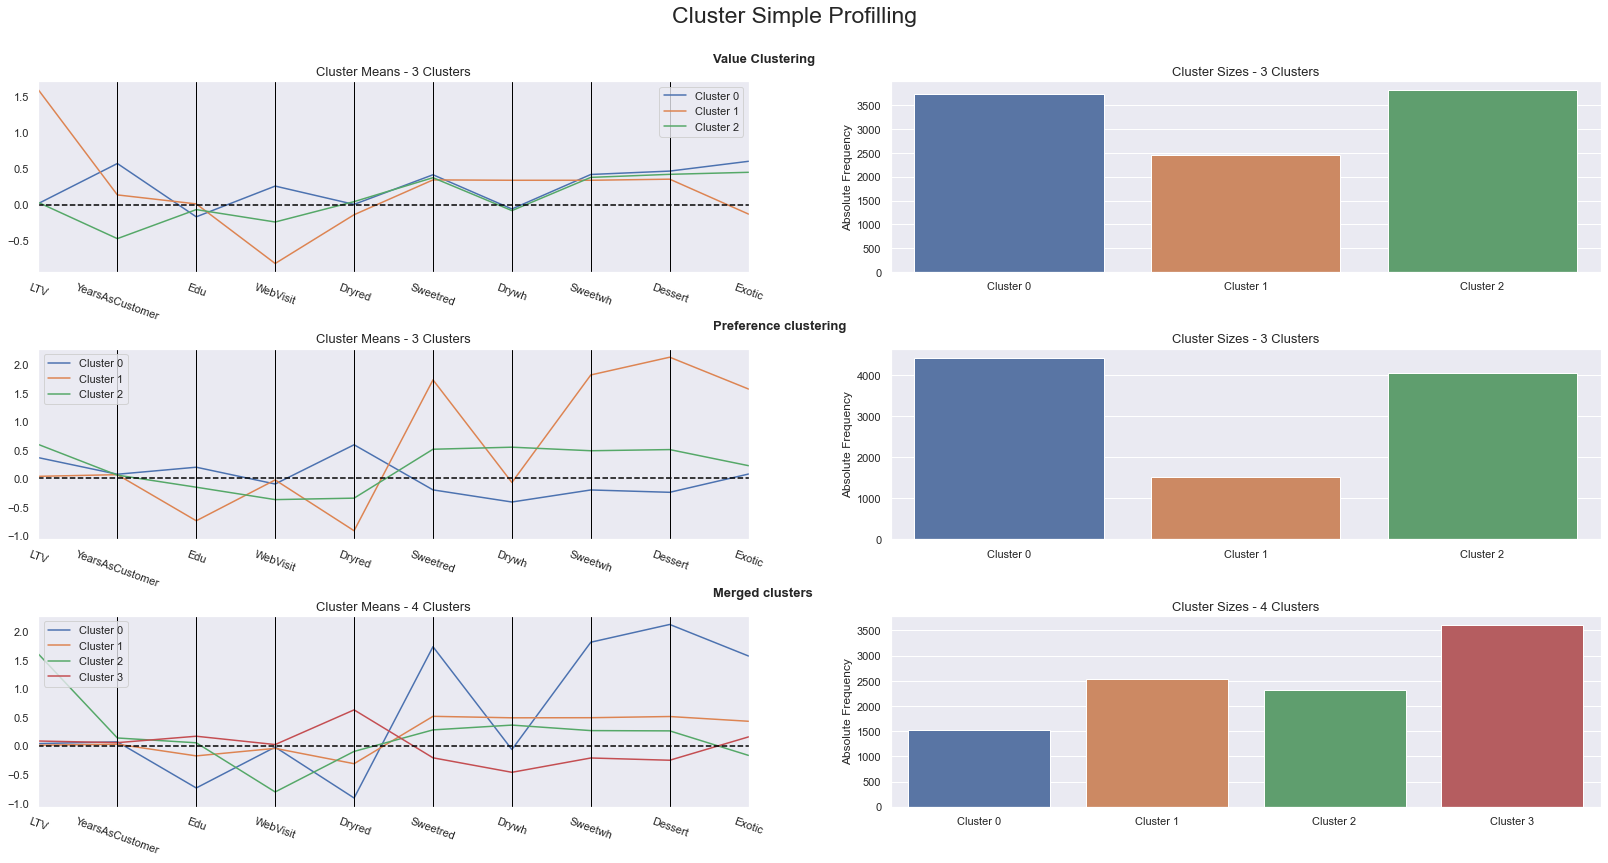

In [96]:
# Profilling each cluster (product, behavior, merged)
cluster_profiles(
    df = df_final_merged[clust + ['value_labels', 'preference_labels', 'merged_labels']], 
    label_columns = ['value_labels', 'preference_labels', 'merged_labels'], 
    figsize = (28, 13), 
    compar_titles = ["Value Clustering", "Preference clustering","Merged clusters"]
)

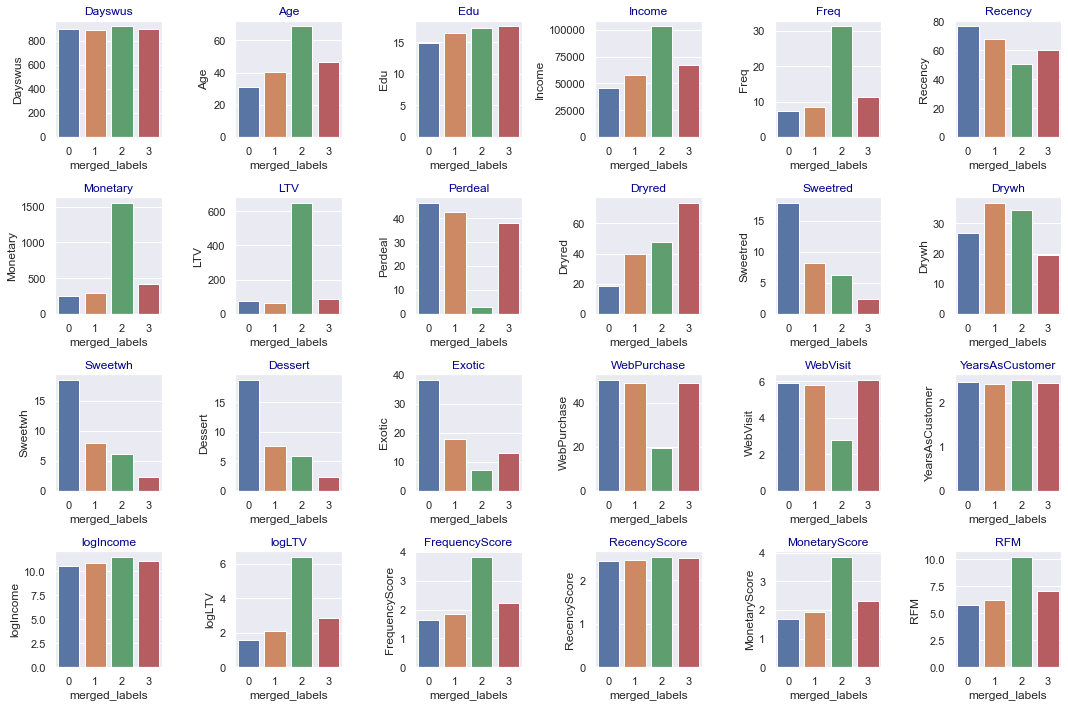

In [97]:
final= df_merged[var + ['merged_labels']].groupby('merged_labels').mean()
#visualization of the metric features of each cluster 
plt.figure(figsize=(15,10))
for i,j in enumerate(final.columns):
    plt.subplot(4,6,i+1)
    sns.barplot(final.index,final[j])
    plt.title(j,fontdict={'color':'darkblue'})
plt.tight_layout()
plt.show()

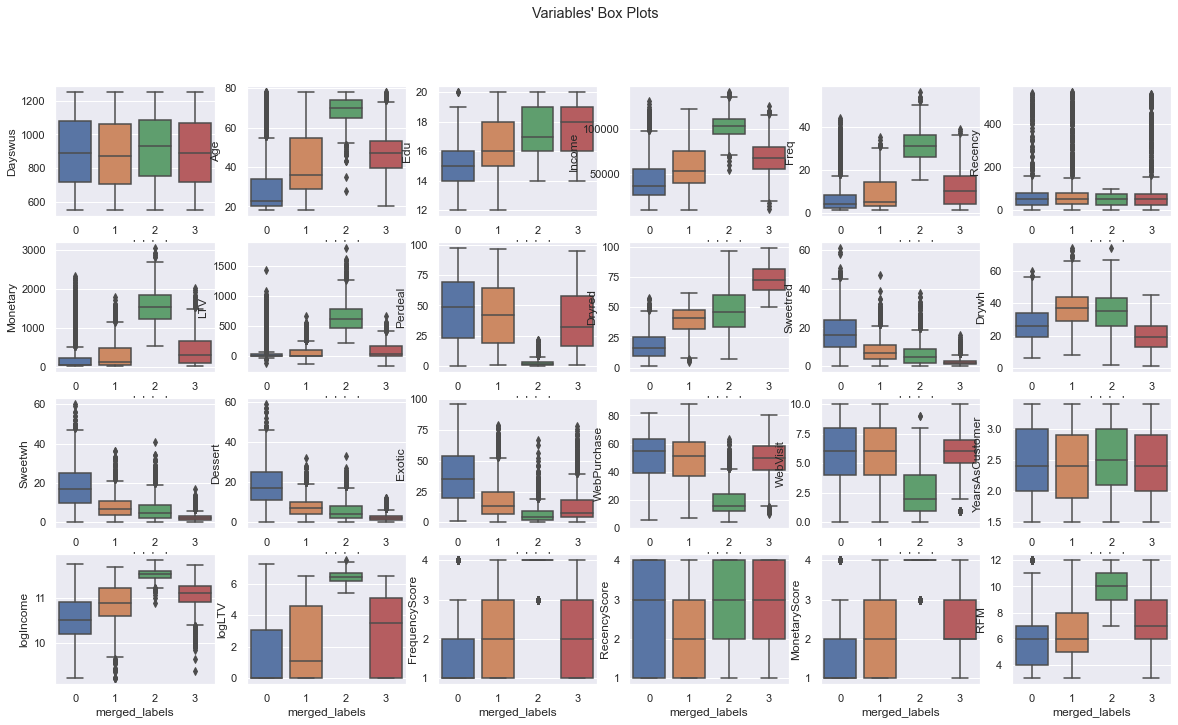

In [98]:
grouped_boxplot("merged_labels", var )

In [99]:
df_merged.loc[df_merged['merged_labels']==0].describe()

Dayswus          Age          Edu         Income         Freq  \
count  1528.000000  1528.000000  1528.000000    1528.000000  1528.000000   
mean    897.716623    31.305628    14.784686   45294.141361     7.249346   
std     206.262748    16.778035     1.442221   26847.499025     8.592575   
min     550.000000    18.000000    12.000000   10000.000000     1.000000   
25%     716.000000    20.000000    14.000000   26942.000000     2.000000   
50%     892.000000    23.000000    15.000000   36040.500000     4.000000   
75%    1083.000000    34.000000    16.000000   54112.750000     7.000000   
max    1249.000000    78.000000    20.000000  130572.000000    44.000000   

           Recency     Monetary          LTV      Perdeal       Dryred  ...  \
count  1528.000000  1528.000000  1528.000000  1528.000000  1528.000000  ...   
mean     76.509162   248.581152    72.407723    46.335733    18.107984  ...   
std      99.050912   441.349027   186.422061    26.943522    11.071394  ...   
min       0.000000     6.000000  -117.000000     0.000000     1.000000  ...   
25%      26.000000    30.000000    -3.000000    24.000000     9.000000  ...   
50%      55.000000    50.000000     0.000000    49.000000    16.000000  ...   
75%      83.000000   188.000000    18.000000    68.000000    25.000000  ...   
max     549.000000  2346.000000  1430.000000    97.000000    58.000000  ...   

       YearsAsCustomer    logIncome       logLTV  FrequencyScore  \
count      1528.000000  1528.000000  1528.000000     1528.000000   
mean          2.460275    10.561583     1.564905        1.636126   
std           0.567084     0.563325     2.240324        0.933158   
min           1.500000     9.210340     0.000000        1.000000   
25%           2.000000    10.201442     0.000000        1.000000   
50%           2.400000    10.492399     0.000000        1.000000   
75%           3.000000    10.898825     2.890372        2.000000   
max           3.400000    11.779680     7.265430        4.000000   

       RecencyScore  MonetaryScore          RFM  value_labels  \
count   1528.000000    1528.000000  1528.000000   1528.000000   
mean       2.451571       1.678010     5.765707      0.921466   
std        1.159346       0.953943     2.272832      0.951535   
min        1.000000       1.000000     3.000000      0.000000   
25%        1.000000       1.000000     4.000000      0.000000   
50%        2.000000       1.000000     5.000000      1.000000   
75%        4.000000       2.000000     7.000000      2.000000   
max        4.000000       4.000000    12.000000      2.000000   

       preference_labels  merged_labels  
count        1528.000000         1528.0  
mean            1.003272            0.0  
std             0.057129            0.0  
min             1.000000            0.0  
25%             1.000000            0.0  
50%             1.000000            0.0  
75%             1.000000            0.0  
max             2.000000            0.0  

[8 rows x 27 columns]

In [100]:
df_merged.loc[df_merged['merged_labels']==1].describe()

Dayswus          Age          Edu         Income         Freq  \
count  2545.000000  2545.000000  2545.000000    2545.000000  2545.000000   
mean    884.665266    40.430620    16.465123   57699.538058     8.467830   
std     204.126269    14.272022     1.597827   22166.029948     7.183055   
min     550.000000    18.000000    12.000000   10000.000000     1.000000   
25%     705.000000    29.000000    15.000000   40733.000000     3.000000   
50%     873.000000    36.000000    16.000000   53449.000000     5.000000   
75%    1062.000000    55.000000    18.000000   75412.000000    14.000000   
max    1249.000000    78.000000    20.000000  122091.000000    35.000000   

           Recency     Monetary          LTV      Perdeal       Dryred  ...  \
count  2545.000000  2545.000000  2545.000000  2545.000000  2545.000000  ...   
mean     67.527468   287.554639    62.184704    42.769901    39.675592  ...   
std      78.801154   335.220844   110.561624    26.091282    11.189617  ...   
min       0.000000     8.000000  -138.000000     1.000000     5.000000  ...   
25%      28.000000    42.000000    -4.000000    19.000000    32.000000  ...   
50%      53.000000   117.000000     3.000000    42.000000    41.000000  ...   
75%      80.000000   485.000000    99.000000    64.000000    48.000000  ...   
max     549.000000  1794.000000   657.000000    96.000000    62.000000  ...   

       YearsAsCustomer    logIncome       logLTV  FrequencyScore  \
count      2545.000000  2545.000000  2545.000000     2545.000000   
mean          2.423143    10.882229     2.125254        1.853045   
std           0.559820     0.418184     2.299142        0.884226   
min           1.500000     9.210340     0.000000        1.000000   
25%           1.900000    10.614794     0.000000        1.000000   
50%           2.400000    10.886483     1.098612        2.000000   
75%           2.900000    11.230722     4.595120        3.000000   
max           3.400000    11.712522     6.487684        4.000000   

       RecencyScore  MonetaryScore          RFM  value_labels  \
count   2545.000000    2545.000000  2545.000000   2545.000000   
mean       2.472692       1.941847     6.267583      1.046758   
std        1.119150       0.884749     2.142412      0.999103   
min        1.000000       1.000000     3.000000      0.000000   
25%        1.000000       1.000000     5.000000      0.000000   
50%        2.000000       2.000000     6.000000      2.000000   
75%        3.000000       3.000000     8.000000      2.000000   
max        4.000000       4.000000    12.000000      2.000000   

       preference_labels  merged_labels  
count        2545.000000         2545.0  
mean            1.999607            1.0  
std             0.019822            0.0  
min             1.000000            1.0  
25%             2.000000            1.0  
50%             2.000000            1.0  
75%             2.000000            1.0  
max             2.000000            1.0  

[8 rows x 27 columns]

In [101]:
df_merged.loc[df_merged['merged_labels']==2].describe()

Dayswus          Age          Edu         Income         Freq  \
count  2317.000000  2317.000000  2317.000000    2317.000000  2317.000000   
mean    919.913681    68.832974    17.151489  103201.758308    31.318947   
std     196.657436     6.364923     1.730782   12079.315778     6.814001   
min     550.000000    28.000000    14.000000   54292.000000    15.000000   
25%     754.000000    65.000000    16.000000   94930.000000    26.000000   
50%     929.000000    70.000000    17.000000  103589.000000    31.000000   
75%    1086.000000    74.000000    19.000000  111202.000000    36.000000   
max    1250.000000    78.000000    20.000000  140628.000000    56.000000   

           Recency     Monetary          LTV      Perdeal       Dryred  ...  \
count  2317.000000  2317.000000  2317.000000  2317.000000  2317.000000  ...   
mean     50.658179  1552.477341   647.687095     2.980578    47.388433  ...   
std      28.895166   432.027052   234.608618     3.155041    17.548950  ...   
min       0.000000   540.000000   218.000000     0.000000     7.000000  ...   
25%      26.000000  1219.000000   468.000000     1.000000    34.000000  ...   
50%      52.000000  1531.000000   608.000000     2.000000    46.000000  ...   
75%      76.000000  1853.000000   785.000000     4.000000    60.000000  ...   
max     100.000000  3052.000000  1791.000000    22.000000    97.000000  ...   

       YearsAsCustomer    logIncome       logLTV  FrequencyScore  \
count      2317.000000  2317.000000  2317.000000     2317.000000   
mean          2.520932    11.537420     6.410754        3.838153   
std           0.540539     0.119510     0.354012        0.368390   
min           1.500000    10.902132     5.384495        3.000000   
25%           2.100000    11.460895     6.148468        4.000000   
50%           2.500000    11.548186     6.410175        4.000000   
75%           3.000000    11.619104     6.665684        4.000000   
max           3.400000    11.853873     7.490529        4.000000   

       RecencyScore  MonetaryScore          RFM  value_labels  \
count   2317.000000    2317.000000  2317.000000        2317.0   
mean       2.545101       3.864480    10.247734           1.0   
std        1.097677       0.342352     1.292298           0.0   
min        1.000000       3.000000     7.000000           1.0   
25%        2.000000       4.000000     9.000000           1.0   
50%        3.000000       4.000000    10.000000           1.0   
75%        4.000000       4.000000    11.000000           1.0   
max        4.000000       4.000000    12.000000           1.0   

       preference_labels  merged_labels  
count        2317.000000         2317.0  
mean            1.293483            2.0  
std             0.955945            0.0  
min             0.000000            2.0  
25%             0.000000            2.0  
50%             2.000000            2.0  
75%             2.000000            2.0  
max             2.000000            2.0  

[8 rows x 27 columns]

In [102]:
df_merged.loc[df_merged['merged_labels']==3].describe()

Dayswus          Age          Edu         Income         Freq  \
count  3611.000000  3611.000000  3611.000000    3611.000000  3611.000000   
mean    893.739684    46.830241    17.494600   67554.759900    11.382443   
std     202.357873    10.117084     1.673704   16986.946013     7.764092   
min     550.000000    20.000000    14.000000   11719.000000     1.000000   
25%     718.500000    39.500000    16.000000   55703.500000     4.000000   
50%     888.000000    47.000000    18.000000   67942.000000    10.000000   
75%    1068.500000    53.000000    19.000000   79558.000000    17.000000   
max    1249.000000    78.000000    20.000000  125962.000000    39.000000   

           Recency     Monetary          LTV      Perdeal       Dryred  ...  \
count  3611.000000  3611.000000  3611.000000  3611.000000  3611.000000  ...   
mean     60.368873   420.223207    88.986707    38.063694    73.507339  ...   
std      65.316834   379.913709   128.445500    24.835488    11.116938  ...   
min       0.000000     8.000000  -178.000000     1.000000    50.000000  ...   
25%      26.000000    89.000000    -4.000000    17.000000    64.000000  ...   
50%      52.000000   304.000000    34.000000    32.000000    73.000000  ...   
75%      78.000000   656.000000   163.500000    58.000000    82.000000  ...   
max     543.000000  2039.000000   665.000000    95.000000    99.000000  ...   

       YearsAsCustomer    logIncome       logLTV  FrequencyScore  \
count      3611.000000  3611.000000  3611.000000     3611.000000   
mean          2.447605    11.085236     2.869781        2.215176   
std           0.555757     0.277050     2.342107        0.905784   
min           1.500000     9.368967     0.000000        1.000000   
25%           2.000000    10.927798     0.000000        1.000000   
50%           2.400000    11.126410     3.526361        2.000000   
75%           2.900000    11.284242     5.096808        3.000000   
max           3.400000    11.743736     6.499787        4.000000   

       RecencyScore  MonetaryScore          RFM  value_labels  \
count   3611.000000    3611.000000  3611.000000   3611.000000   
mean       2.522570       2.318748     7.056494      1.019108   
std        1.120807       0.878194     2.151626      0.999956   
min        1.000000       1.000000     3.000000      0.000000   
25%        2.000000       2.000000     6.000000      0.000000   
50%        3.000000       2.000000     7.000000      2.000000   
75%        4.000000       3.000000     9.000000      2.000000   
max        4.000000       4.000000    12.000000      2.000000   

       preference_labels  merged_labels  
count             3611.0         3611.0  
mean                 0.0            3.0  
std                  0.0            0.0  
min                  0.0            3.0  
25%                  0.0            3.0  
50%                  0.0            3.0  
75%                  0.0            3.0  
max                  0.0            3.0  

[8 rows x 27 columns]

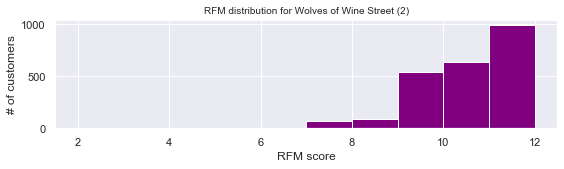

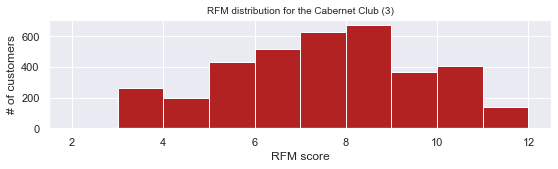

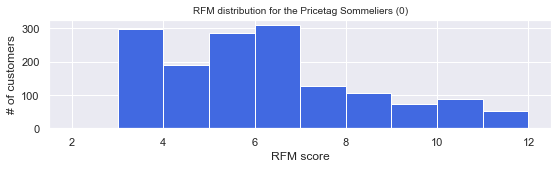

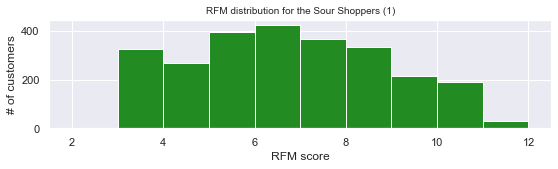

In [103]:
#RFM variable by final clusters

#plot 3 
plt.figure(figsize=(9,2))
plt.hist(df_merged[df_merged.merged_labels==2].RFM, color = "purple",range= (2, 12))
plt.ylabel("# of customers")
plt.xlabel("RFM score")
plt.title("RFM distribution for Wolves of Wine Street (2)", size=10)

#plot 4 
plt.figure(figsize=(9,2))
plt.hist(df_merged[df_merged.merged_labels==3].RFM, color = "firebrick",range= (2, 12))
plt.ylabel("# of customers")
plt.xlabel("RFM score")
plt.title("RFM distribution for the Cabernet Club (3)", size=10)

#plot 1
plt.figure(figsize=(9,2))
plt.hist(df_merged[df_merged.merged_labels==0].RFM, color = "royalblue", range= (2, 12))
plt.ylabel("# of customers")
plt.xlabel("RFM score")
plt.title("RFM distribution for the Pricetag Sommeliers (0)", size=10)

#plot 2
plt.figure(figsize=(9,2))
plt.hist(df_merged[df_merged.merged_labels==1].RFM, color = "forestgreen", range= (2, 12))
plt.ylabel("# of customers")
plt.xlabel("RFM score")
plt.title("RFM distribution for the Sour Shoppers (1)", size=10)

plt.show()

In [104]:
df_merged.to_csv('df_clustered.csv', index_label='Custid')